# PPCA

In [1]:
import torch
import tensorboard
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torchtyping import TensorType
from omegaconf import DictConfig
from lightning_pose.utils.scripts import get_imgaug_transform, get_dataset, get_data_module, get_loss_factories
from lightning_pose.utils.io import return_absolute_data_paths
import hydra
import os
import pandas as pd
import cvxpy as cp
from typing import Optional, Tuple, Dict, Any, Union
from PIL import Image
from typeguard import typechecked
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [2]:
def get_base_config(config_dir: str, config_name: str) -> DictConfig:
    assert(os.path.isdir(config_dir))
    hydra.initialize_config_dir(base_config_dir)
    cfg = hydra.compose(config_name="config")
    return cfg
from typing import List

In [3]:
def resize_keypoints(cfg, keypoints_pred):
    """reshape to training dims for pca losses, which are optimized for these dims"""
    x_resize = cfg.data.image_resize_dims.width
    x_og = cfg.data.image_orig_dims.width
    keypoints_pred[:, :, 0] = keypoints_pred[:, :, 0] * (x_resize / x_og)
    # put y vals back in original pixel space
    y_resize = cfg.data.image_resize_dims.height
    y_og = cfg.data.image_orig_dims.height
    keypoints_pred[:, :, 1] = keypoints_pred[:, :, 1] * (y_resize / y_og)
    return keypoints_pred

In [4]:
dataset_name = "rick-pca-configs"
base_config_dir = "/home/jovyan/rick-pca-configs"
base_save_dir = "/home/jovyan/"
cfg = get_base_config(base_config_dir, "config")

In [5]:
def get_keypoint_names(csv_data: pd.DataFrame, header_rows: List[int]) -> List[str]:
    if header_rows == [0,1,2]:
        keypoint_names = [c[1] for c in csv_data.columns[1::2]]
    elif header_rows == [1,2]:
        keypoint_names = [c[0] for c in csv_data.columns[1::2]]
    return keypoint_names

In [6]:
# load ground truth labels
csv_file = os.path.join(cfg.data.data_dir, cfg.data.csv_file)
csv_data = pd.read_csv(csv_file, header=list(cfg.data.header_rows))
keypoints_gt = csv_data.iloc[:, 1:].to_numpy().reshape(csv_data.shape[0], -1, 2)

keypoint_names = get_keypoint_names(csv_data, cfg.data.header_rows)

In [7]:
# load preds
pred_file = "/home/jovyan/lightning-pose/multirun/2022-06-24/14-39-41/0/predictions.csv"
pred_df = pd.read_csv(pred_file, header=[0, 1, 2], index_col=0)
if pred_df.keys()[-1][0] == "set":
    # these are predictions on labeled data; get rid of last column that
    # contains info about train/val/test set
    is_video = False
    tmp = pred_df.iloc[:, :-1].to_numpy().reshape(pred_df.shape[0], -1, 3)
keypoints_pred = tmp[:, :, :2]  # shape (samples, n_keypoints, 2)
confidences = tmp[:, :, -1]  # shape (samples, n_keypoints)
print(keypoints_pred.shape)

(1045, 17, 2)


In [8]:
# save_dir = os.path.join(base_save_dir, dataset_name)
save_dir = "/home/jovyan/lightning-pose"

loss_type = "pca_singleview" # Change for different loss functions
error_metric = "reprojection_error" # for pca only
# define models
train_frames = 75 # 75 for this model or 1 for the entire training dataset

pca_loss = None
datamodule = None
model_cfg = cfg.copy()
model_cfg.training.train_frames = train_frames
model_cfg.model.losses_to_use = [loss_type]
from lightning_pose.utils.pca import KeypointPCA
data_dir, video_dir = return_absolute_data_paths(data_cfg=model_cfg.data)
imgaug_transform = get_imgaug_transform(cfg=model_cfg)
dataset = get_dataset(cfg=model_cfg, data_dir=data_dir, imgaug_transform=imgaug_transform)
data_module = get_data_module(cfg=model_cfg, dataset=dataset, video_dir=video_dir)
data_module.setup()
# compute pca params
loss_factories = get_loss_factories(cfg=model_cfg, data_module=data_module)
pca_loss = loss_factories["unsupervised"].loss_instance_dict[loss_type]

/home/jovyan/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 104, test set: 105


[/opt/dali/dali/operators/reader/loader/video_loader.h:178] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.
[/opt/dali/dali/operators/reader/nvdecoder/nvdecoder.cc:80] Warning: Decoding on a default stream. Performance may be affected.


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 75, val set: 104, test set: 105
Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.374 0.198 0.182 0.101 0.054 0.029 0.02  0.011 0.008 0.005 0.005 0.004
 0.003 0.002 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.992


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:326: UserWarning: Using empirical epsilon=0.173 * multiplier=1.000 -> total=0.173 for pca_singleview loss
  warnings.warn(


In [9]:
# resize both arrays to training dims
keypoints_pred = resize_keypoints(model_cfg, keypoints_pred)
keypoints_gt = resize_keypoints(model_cfg, keypoints_gt)

In [10]:
# remove redundant keypoints for pca singleview
#pca_cols = pca_loss.pca.columns_for_singleview_pca
keypoints_pred = pca_loss.pca._format_data(data_arr=torch.tensor(keypoints_pred).reshape(keypoints_pred.shape[0], -1))
keypoints_gt = pca_loss.pca._format_data(data_arr=torch.tensor(keypoints_gt).reshape(keypoints_gt.shape[0], -1))
confidences = confidences[:, cfg.data.columns_for_singleview_pca]
#heatmap_arr = heatmaps_arr[:, cfg.data.columns_for_singleview_pca, :, :]

In [11]:
# FOR SINGLEVIEW, RICK ONLY
keypoint_names = [kp for kp in keypoint_names if kp not in ['obs_top','obsHigh_bot','obsLow_bot']]

In [12]:
# data array without removing rows with missing entries
# allready resized 
full_data_arr = pca_loss.pca._format_data(data_arr=pca_loss.pca._get_data())

In [13]:
full_data_arr.shape

torch.Size([75, 28])

In [14]:
from lightning_pose.utils.pca import extract_blocks_from_inds

In [15]:
# test_mat = torch.tensor([[1., 2., 3.], [4., 5., 6.], [7., 8., 9.]])
# print(test_mat)
# print(extract_blocks_from_inds(valid_inds=[0,2], cov_mat=test_mat))

In [16]:
class PPCA(pl.LightningModule):
    def __init__(self, observation_dim: int, latent_dim: int) -> None:
        super().__init__()
        self.observation_dim=observation_dim
        self.latent_dim=latent_dim
        self.W = torch.nn.Parameter(data=torch.randn((observation_dim, latent_dim)))
        self.mu = torch.nn.Parameter(data=torch.randn((observation_dim, 1)))
        self.log_sigma_2 = torch.nn.Parameter(data=torch.tensor(0.0))
        
        # diagnostics
        self.loss = []
        self.loss_obs = []
        self.loss_miss = []
        self.norms = []
    
    def M(self) -> TensorType["latent_dim", "latent_dim"]:
        return self.W.T @ self.W + torch.exp(self.log_sigma_2)* torch.eye(self.latent_dim)
    
    def compute_posterior(self, observation):
        valid_inds = torch.where(~torch.isnan(observation))[0]
        M_inv = torch.linalg.inv(self.M())
        posterior_cov = torch.exp(self.log_sigma_2) * M_inv
        valid_W = self.W[valid_inds, :]
        mean_subtracted_observation = observation[valid_inds] - self.mu[valid_inds]
        posterior_mean = M_inv @ valid_W.T @ mean_subtracted_observation
        return posterior_mean, posterior_cov
    
    def predict(self, posterior_mean: TensorType["n_components_kept", 1, float], posterior_cov: TensorType["n_components_kept", "n_components_kept", float]) -> Tuple[TensorType["observation_dim", 1, float], TensorType["observation_dim", "observation_dim", float]]:
        """compute the predictive distribution:
        p(x) = \mathcal{N}(mu, Sigma)
        where mu = A*posterior_mean + b
        ans Sigma = A*posterior_cov*A^{\top} + R
        compute preds for all data points, no missing vals.
        you can later pick those dims of interest"""
        predictive_mean = self.W @ posterior_mean + self.mu
        predictive_covariance = self.W @ posterior_cov @ self.W.T + torch.linalg.inv(torch.exp(self.log_sigma_2)*torch.eye(self.observation_dim))
        return predictive_mean, predictive_covariance
    
    def reconstruct(self, observation: TensorType["observation_dim", -1, float]) -> Dict[str, Tuple[TensorType, TensorType]]:
        """
        Compute the reconstruction of the data, given the posterior mean and covariance
        """
        # first compute the posterior mean and covariance
        posterior_mean, posterior_covariance = self.compute_posterior(observation)
        # then compute the predictive distribution
        predictive_mean, predictive_covariance = self.predict(posterior_mean, posterior_covariance)
        
        return {"posterior": (posterior_mean, posterior_covariance), "reconstruction": (predictive_mean, predictive_covariance)}
    
    def initialize_params(self, W: Optional[torch.Tensor] = None, \
                          mu: Optional[torch.Tensor] = None, \
                          sigma_2: Optional[torch.Tensor] = None) -> None:
        if W is not None:
            assert(self.W.data.shape == W.shape)
            self.W.data = torch.clone(W).contiguous()
        
        if mu is not None:
            assert(self.mu.data.shape == mu.shape)
            self.mu.data = torch.clone(mu).contiguous()
        
        if sigma_2 is not None:
            assert(self.log_sigma_2.data.shape == sigma_2.shape)
            self.log_sigma_2.data = torch.clone(torch.log(sigma_2)).contiguous()
    
    def compute_marginal_mean_cov(self) -> Tuple[torch.Tensor]:
        cov = self.W @ self.W.T + torch.exp(self.log_sigma_2)*torch.eye(self.W.shape[0])
        return self.mu, cov
        
    def compute_loss(self, data):
        mask = ~torch.isnan(data)
        mu, cov = self.compute_marginal_mean_cov()
        # loop over n = 1, ..., N
        mll = torch.tensor(0., device=data.device)
        for n, x_n in enumerate(data):
            # identify missing values and select right entries
            valid_inds = torch.where(mask[n,:])[0]
            mu_valid = mu[valid_inds]
            cov_valid = extract_blocks_from_inds(valid_inds=valid_inds, cov_mat=cov)
            cov_valid += torch.eye(cov_valid.shape[0])*1e-6
            x_valid = x_n[valid_inds]
            distr = torch.distributions.MultivariateNormal(mu_valid.squeeze(), cov_valid)
            # compute log probability for current n
            mll += distr.log_prob(x_valid)
        return -mll / data.shape[0]
    
    def train_dataloader(self, observations: torch.Tensor):
        dataset = TensorDataset(observations)
        return DataLoader(dataset, batch_size=observations.shape[0])
    
    def configure_optimizers(self):
        return torch.optim.LBFGS(self.parameters())
        
    def training_step(self, batch, batch_idx):
        loss = self.compute_loss(batch[0])#.clone().contiguous())
        self.loss.append(loss.detach().cpu().numpy())
        self.log("average_nll", loss, prog_bar=True)
        
        # for debugging purpuses, slows things down a bit
        self.record_training_metrics(batch)
        
        return loss
    
    def record_training_metrics(self, batch) -> None:
        # for debugging purpuses, slows things down a bit
        with torch.no_grad():
            obs_w_miss_vals = (torch.isnan(batch[0]).sum(1)>0)
            loss_miss = self.compute_loss(batch[0][obs_w_miss_vals])
            loss_obs = self.compute_loss(batch[0][~obs_w_miss_vals])
            self.loss_miss.append(loss_miss.detach().cpu().numpy())
            self.loss_obs.append(loss_obs.detach().cpu().numpy())
            
            # perform posterior predict
            recons = []
            for i, data in enumerate(batch[0]):
                recons.append(ppca.reconstruct(data.reshape(-1,1)))
            reconstructions = torch.hstack([rec["reconstruction"][0].detach().cpu() for rec in recons]).T
            # now we wanna compute pixel error for missing and observed images in training
            arr_reshaped = batch[0].reshape(batch[0].shape[0], -1, 2)
            recon_reshaped = reconstructions.reshape(reconstructions.shape[0], -1, 2)
            norms = torch.linalg.norm(arr_reshaped - recon_reshaped, axis=2) # all images, single value per bodypart
            # mean_norms = torch.nanmean(norms, axis=1) # consider logging w/o mean
            self.norms.append(norms)
        
    
    def validation_step(self, batch, batch_idx):
        obs_w_miss_vals = batch[0][(torch.isnan(batch[0]).sum(1)>0)]
        # reconstruct full compute err
        # reconstruct missing compute err

In [93]:
@typechecked
class PPCAOutlierDetector:
    """
    Outlier detector using PPCA/LGSSM.
    """
    def __init__(
        self,
        fitted_model: Union[PPCA, Any] = None,
        included_keypoints: List[str] = None,
        displacement_thresh: float = 40.0,
        **kwargs,
    ):
        self.model = fitted_model # model after learning. has to have .reconstruct()
        self.included_keypoints = included_keypoints
        self.displacement_thresh = displacement_thresh
    
    def loo_reconstruction(self, pred_vector: TensorType["num_keypoints"]) -> List[TensorType["num_keypoints"]]:
        pred_reshaped = pred_vector.clone().reshape(-1,2)
        recon_results = []
        # loop over all the keypoints
        for i in range(pred_reshaped.shape[0]):
            temp_preds = pred_reshaped.clone()
            if temp_preds[i,:].isnan().any():
                # if it's already a nan from previous iteration, return a vector of nans
                recon_result = torch.ones((pred_vector.shape[0]))*torch.nan
                recon_results.append(recon_result)
            else:
                # remove keypoint from the prediction vector
                temp_preds[i,:] = torch.nan
                # LinearGaussian.reconstruct preds with missing data
                recon_result = self.model.reconstruct(temp_preds.reshape(-1,1))
                # add the mean reconstruction to the list
                recon_results.append(recon_result["reconstruction"][0].reshape(-1))
        return recon_results
    
    def compute_difference_norms(self, pred_vector: TensorType["num_keypoints_times_two"], recon_list: List[TensorType["num_keypoints_times_two"]]) -> TensorType["num_keypoints", "num_keypoints"]:
        # check how much each point moved
        norms_list = []
        # loop over all the loo reconstructions
        for i in range(len(recon_list)):
            recons_temp = recon_list[i]
            # reshape preds and recons to be of shape (num_keypoints, 2)
            pred_reshaped = pred_vector.clone().reshape(-1,2)
            recons_temp_reshaped = recons_temp.reshape(-1,2)
            # for each reconstructed keypoint, compute the norm of the difference
            norms = torch.linalg.norm(pred_reshaped - recons_temp_reshaped, dim=1)
            norms_list.append(norms.unsqueeze(-1))
        all_norms = torch.cat(norms_list, dim=-1)
        return all_norms
    
    @staticmethod
    def find_nanmax(tensor: TensorType["num_keypoints", float]) -> Tuple[float, int]:
        """
        Find the maximum value in a tensor, ignoring the masked values
        """
        # define a bool which is true for all non-nan values
        non_nan_mask = ~torch.isnan(tensor)
        # find the maximum value in the tensor
        max_val = torch.max(tensor[non_nan_mask])
        # find the indices of the maximum value
        max_ind = torch.where(tensor == max_val)[0]
        # return the indices of the maximum value
        return float(max_val), int(max_ind)
    
    def find_max_norm(self, all_norms: TensorType["num_keypoints", "num_keypoints"], included_keypoint_names: List[str]) -> Tuple[TensorType[()], int, str]:
        # get diags of all_norms
        diag_norms = all_norms.diag()
        # get the max norm ind
        max_norm_val, max_norm_ind = self.find_nanmax(diag_norms) # = int(torch.argmax(diag_norms))
        # get the max norm
        max_norm = diag_norms[max_norm_ind]
        # get the keypoint name
        max_norm_name = included_keypoint_names[max_norm_ind]
        return max_norm, max_norm_ind, max_norm_name
    
    def iterative_reconstruction(self, pred_vector: TensorType["num_keypoints_times_two"], norm_change_thresh: float, included_keypoint_names: List[str]) -> TensorType["num_keypoints_times_two"]:
        # TODO: consider norm_change_thresh as a parameter of self, verify that the logic of the procedure is correct. 
        # outer loop:
        preds = pred_vector.clone()
        while True:
            print("========================================================")
            # get the reconstruction results
            recon_list = self.loo_reconstruction(preds)
            # compute the norms
            norms = self.compute_difference_norms(preds, recon_list)
            # find the maximum norm change
            max_norm, max_norm_ind, max_norm_name = self.find_max_norm(norms, included_keypoint_names)
            print(f"max_norm: {max_norm}")
            print(f"max_norm_ind: {max_norm_ind}")
            print(f"max_norm_name: {max_norm_name}")
            # if the max norm is less than the threshold, break
            if max_norm < norm_change_thresh:
                print("norm is < {}, breaking".format(norm_change_thresh))
                break
            else:
                print("norm is > {}, masking bodypart".format(norm_change_thresh))
                # remove the keypoint and continue
                preds = preds.reshape(-1,2) # reshape to num_keypoints, 2
                preds[max_norm_ind,:] = torch.nan # make (x,y) coords of problematic bp == nan
                preds = preds.reshape(-1) # reshape to num_keypoints X 2
        
        #print(torch.sum(torch.isnan(preds.reshape(preds.shape[0], -1, 2))))
            
        return preds
    
    def fix_outliers(self, pred_vector: TensorType["num_keypoints_times_two"], iterative_output: TensorType["num_keypoints_times_two"]) -> TensorType["num_keypoints_times_two"]:
        post_reconstruction = self.model.reconstruct(iterative_output.float().reshape(-1,1))
        recon_means = post_reconstruction["reconstruction"][0]
        nan_outputs = torch.isnan(iterative_output.reshape(-1,2)).any(dim=1)
        replaced_pred_vector = pred_vector.clone().float().reshape(-1,2)
        replaced_pred_vector[nan_outputs, :] = recon_means.reshape(-1,2)[nan_outputs, :]
        return replaced_pred_vector.reshape(-1)
    
    def flag_and_fix_single_obs(self, pred_vector: TensorType["num_keypoints_times_two"]) -> Dict[str, TensorType["num_keypoints_times_two"]]:
        # iterative reconstruction
        with torch.no_grad():
            iterative_output = self.iterative_reconstruction(pred_vector, self.displacement_thresh, self.included_keypoints)
            # fix outliers
            fixed_output = self.fix_outliers(pred_vector, iterative_output)
        return {"flagged": iterative_output, "fixed": fixed_output}


1. initialize ppca
2. initialize parameters with pca ones
3. init `Trainer`
4. `trainer.fit()`

In [18]:
# initialize parameters
evals: TensorType["n_components_kept"]= torch.tensor(pca_loss.pca.pca_object.explained_variance_).to("cpu").float()
sigma_2: TensorType[(), float] =  torch.mean(evals[pca_loss.pca._n_components_kept:]).to("cpu").float()
D = torch.diag(evals[:pca_loss.pca._n_components_kept]).to("cpu").float()
evecs = pca_loss.pca.parameters["kept_eigenvectors"].to("cpu")
W: TensorType["observation_dim", "n_components_kept"] = evecs.T @ torch.sqrt(D - sigma_2*torch.eye(D.shape[0], dtype=torch.float))
mu = pca_loss.pca.parameters['mean'].reshape(-1,1)

In [19]:
ppca = PPCA(observation_dim=W.shape[0], latent_dim=W.shape[1])

In [20]:
ppca.initialize_params(W=W.to(ppca.device), mu=mu.to(ppca.device), sigma_2=sigma_2.to(ppca.device))

In [21]:
train_dataloader = ppca.train_dataloader(observations=full_data_arr.to(ppca.device))

In [22]:
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="ppca")

In [23]:
# for i, batch in enumerate(train_dataloader):
#     print(i)
#     print(batch[0].shape)

In [24]:
# (torch.isnan(batch[0]).sum(1)>0)

In [25]:
# batch[0][(torch.isnan(batch[0]).sum(1)>0)].shape

In [26]:
# loss

In [27]:
# list(ppca.parameters())

In [28]:
trainer = pl.Trainer(logger=logger, log_every_n_steps=1, max_epochs=10)
trainer.fit(ppca, train_dataloader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1812: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name | Type | Params
------------------------------
------------------------------
393       Trainable params
0         Non-trainable params
393       Total params
0.002     Total estimated model params size (MB)
/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.p

Training: 0it [00:00, ?it/s]

2022-07-08 17:37:43.536583: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


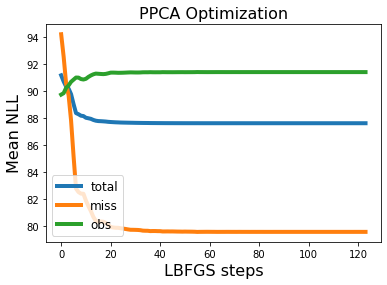

In [29]:
plt.plot(ppca.loss, linewidth=4, label="total")
plt.plot(ppca.loss_miss, linewidth=4, label="miss")
plt.plot(ppca.loss_obs, linewidth=4, label="obs")
plt.xlabel("LBFGS steps", fontsize=16)
plt.ylabel("Mean NLL", fontsize=16)
plt.title("PPCA Optimization", fontsize=16)
plt.legend(fontsize=12)

In [30]:
# untrained ppca
ppca_untrained = PPCA(observation_dim=W.shape[0], latent_dim=W.shape[1])
ppca_untrained.initialize_params(W=W.to(ppca_untrained.device), mu=mu.to(ppca_untrained.device), sigma_2=sigma_2.to(ppca_untrained.device))

In [31]:
# assert that parameters have indeed changed
assert ~torch.allclose(ppca_untrained.W, ppca.W)
assert ~torch.allclose(ppca_untrained.mu, ppca.mu)
assert ~torch.allclose(ppca_untrained.log_sigma_2, ppca.log_sigma_2)

Compare explained variance on fully observed frames.

In [32]:
#print("shape", ppca.norms[0].shape)
norms = torch.stack([ppm for ppm in ppca.norms], axis=0).numpy()

In [33]:
# print(csv_data.columns.levels[0])

The following plot breaks down the error per bodypart, across all 75 frames whenever these are available.

In [34]:
# break down per included/excluded images
obs_w_miss_vals = (torch.isnan(full_data_arr).sum(1)>0)

In [35]:
norms.shape

(124, 75, 14)

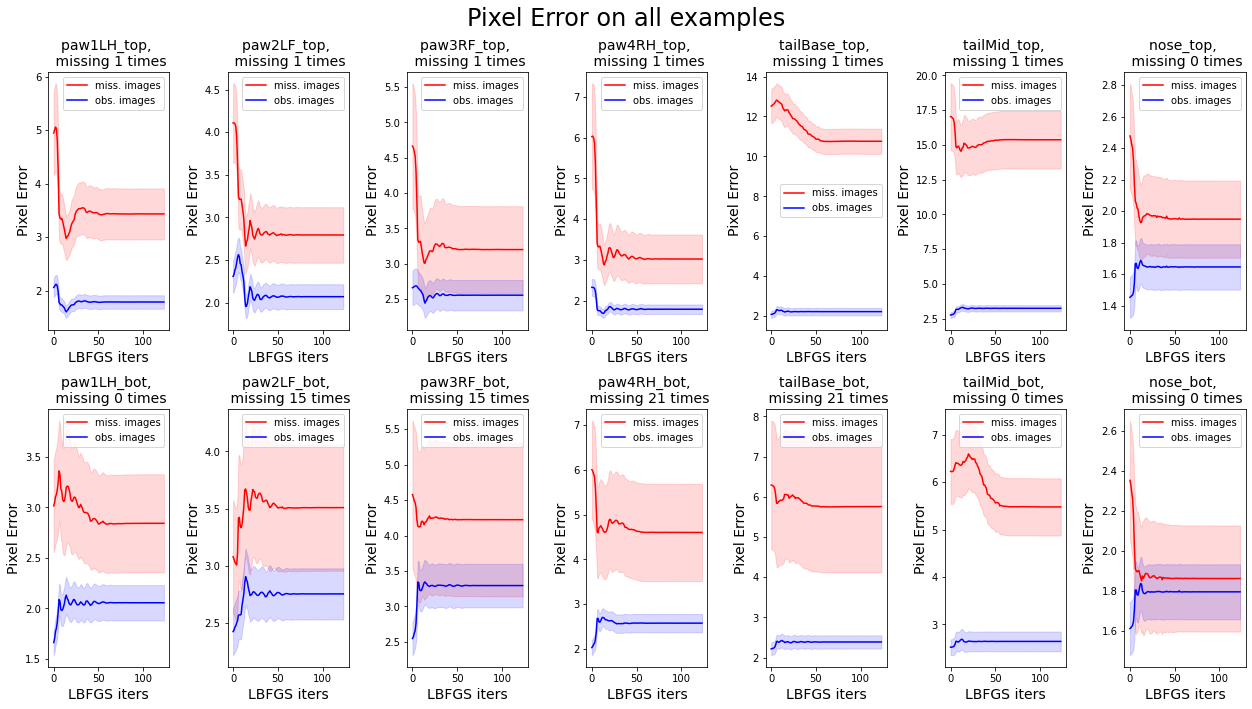

In [36]:
missing_counts = torch.isnan(full_data_arr).sum(0)
obs_w_miss_vals = (torch.isnan(full_data_arr).sum(1)>0)

norms_miss = norms[:, obs_w_miss_vals,:]
norm_obs = norms[:, ~obs_w_miss_vals,:]
per_bp_mean_norms_miss = np.nanmean(norms_miss, 1) # averaged across images
per_bp_std_norm_miss = np.nanstd(norms_miss, 1) / np.sqrt(norms_miss.shape[1])  # across images

per_bp_mean_norms_obs = np.nanmean(norm_obs, 1) # averaged across images
per_bp_std_norm_obs = np.nanstd(norm_obs, 1) / np.sqrt(norm_obs.shape[1])  # across images


fig, axs = plt.subplots(2, 7, figsize = (17.5, 10.))
axs = axs.flatten()
y_same_scale = False
lim_low = 0.0
lim_high = 20.0
for i in range(len(axs)):
    # miss
    axs[i].plot(per_bp_mean_norms_miss[:,i], color='r', label="miss. images")
    axs[i].fill_between(np.arange(per_bp_mean_norms_miss.shape[0]), \
                        per_bp_mean_norms_miss[:,i]-per_bp_std_norm_miss[:,i], \
                        per_bp_mean_norms_miss[:,i]+per_bp_std_norm_miss[:,i], alpha=0.15, color='r')
    # obs
    axs[i].plot(per_bp_mean_norms_obs[:,i], color='b', label="obs. images")
    axs[i].fill_between(np.arange(per_bp_mean_norms_obs.shape[0]), \
                        per_bp_mean_norms_obs[:,i]-per_bp_std_norm_obs[:,i], \
                        per_bp_mean_norms_obs[:,i]+per_bp_std_norm_obs[:,i], alpha=0.15, color='b')
    
    # general 
    axs[i].set_xlabel("LBFGS iters", fontsize=14)
    axs[i].set_ylabel("Pixel Error", fontsize=14)
    if y_same_scale:
        axs[i].set_ylim([lim_low, lim_high])
    axs[i].set_title("%s, \n missing %i times" %(keypoint_names[i], missing_counts[i].cpu().numpy()), fontsize=14)
    axs[i].legend()

fig.suptitle("Pixel Error on all examples", fontsize=24)
fig.tight_layout()
fig.savefig("pix_err_ppca_training.png")

In [37]:
# keypoint_names = data_module.dataset.keypoint_names
# keypoint_names = [kp for kp in keypoint_names if kp not in ['obs_top','obsHigh_bot','obsLow_bot']]

In [38]:
# organize norms
mean_norms_missing_frames = np.nanmean(norms[:, obs_w_miss_vals,:], axis=(1,2))
mean_norms_obs_frames = np.nanmean(norms[:, ~obs_w_miss_vals,:], axis=(1,2))

In [39]:
mean_norms_missing_frames.shape

(124,)

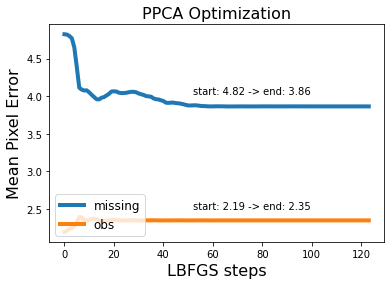

In [40]:
#plt.plot(mean_norms.numpy(), linewidth=4, label="total")
plt.plot(mean_norms_missing_frames, linewidth=4, label="missing")
plt.plot(mean_norms_obs_frames, linewidth=4, label="obs")
plt.xlabel("LBFGS steps", fontsize=16)
plt.ylabel("Mean Pixel Error", fontsize=16)
plt.title("PPCA Optimization", fontsize=16)
mid_ind = mean_norms_obs_frames.shape[0]//2 - 10
vertical_pad = 0.15
plt.text(x= mid_ind, y = mean_norms_obs_frames[mid_ind]+ vertical_pad, \
         s= "start: %.2f -> end: %.2f" %(mean_norms_obs_frames[0], mean_norms_obs_frames[-1]))
plt.text(x= mid_ind, y = mean_norms_missing_frames[mid_ind]+ vertical_pad, \
         s= "start: %.2f -> end: %.2f" %(mean_norms_missing_frames[0], mean_norms_missing_frames[-1]))

plt.legend(fontsize=12, loc="lower left");

## Reconstruct predictions
use first and last models. 
compute pix err.
display images.

In [41]:
from typing import Union
def scatter_and_line(gt_vector: np.ndarray, pred_vector: np.ndarray, label: str, color: str, marker: str, s: Union[int, List[int]], alpha_marker: float, alpha_line: float, show_nans: bool = False):
    if show_nans:
        mask = np.arange(gt_vector[:,0].shape[0])
    else:
        mask = ~np.isnan(gt_vector[:,0])
    plt.scatter(pred_vector[mask,0], pred_vector[mask,1], c=color, label=label,marker=marker, s=s, alpha=alpha_marker)
    for i in range(gt_vector.shape[0]):
        if ~np.isnan(gt_vector[i,0]):
            plt.plot([gt_vector[i,0], pred_vector[i,0]], [gt_vector[i,1], pred_vector[i,1]], linewidth=2.0, c=color, alpha=alpha_line)


In [42]:
from sklearn.metrics._regression import explained_variance_score, r2_score
from lightning_pose.utils.pca import r_squared_multivariate

In [43]:
# reproject fully observed data with pca
pca_reprojection = pca_loss.pca.reproject(pca_loss.pca.data_arr.to("cuda"))
pca_reprojection.shape

torch.Size([51, 28])

My r_squared_multivariate function gives a value that corresponds with pca output. while the sklearn funcs produce lower vals.
here validating that the output of pca from sklearn, on the data on which it was fitted, provides the same explained variance as above.

In [44]:
print(r2_score(pca_loss.pca.data_arr.cpu().numpy().T, pca_reprojection.cpu().numpy().T))
print(explained_variance_score(pca_loss.pca.data_arr.cpu().numpy().T, pca_reprojection.cpu().numpy().T))
print(r_squared_multivariate(pca_loss.pca.data_arr.cpu(), pca_reprojection.cpu()))

0.9994225542481
0.9994239655195498
tensor(0.9923)


reconstruct full data arr and see explained variances. mask missing data.

In [45]:
def compute_r_squared(full_data_arr, reconstructions) -> Dict[str, float]:
    # make room for gt data we will infill
    filled_in_gt = torch.clone(full_data_arr).float()
    # find nans
    isnan = torch.isnan(full_data_arr)
    examples_w_missing_values = isnan.sum(1) > 0
    # infull
    filled_in_gt[isnan] = reconstructions[isnan]
    # shouldn't affect things
    total_r_squared = r_squared_multivariate(filled_in_gt, \
                             reconstructions).item()
    obs_r_squared = r_squared_multivariate(filled_in_gt[~examples_w_missing_values,:], \
                             reconstructions[~examples_w_missing_values,:]).item()
    miss_r_squared = r_squared_multivariate(filled_in_gt[examples_w_missing_values,:], \
                             reconstructions[examples_w_missing_values,:]).item()
    return {"total": total_r_squared, "observed": obs_r_squared, "missing": miss_r_squared}

In [46]:
recons = []
for i, data in enumerate(full_data_arr):
    recons.append(ppca.reconstruct(data.reshape(-1,1).float()))
reconstructions = torch.hstack([rec["reconstruction"][0].detach().cpu() for rec in recons]).T
print(reconstructions.shape)

torch.Size([75, 28])


In [47]:
r_squared_new = compute_r_squared(full_data_arr, reconstructions)

In [48]:
recons_untrained = []
for i, data in enumerate(full_data_arr):
    recons_untrained.append(ppca_untrained.reconstruct(data.reshape(-1,1).float()))
reconstructions_untrained = torch.hstack([rec["reconstruction"][0].detach().cpu() for rec in recons_untrained]).T
print(reconstructions_untrained.shape)

torch.Size([75, 28])


In [49]:
r_squared_untrained = compute_r_squared(full_data_arr, reconstructions_untrained)

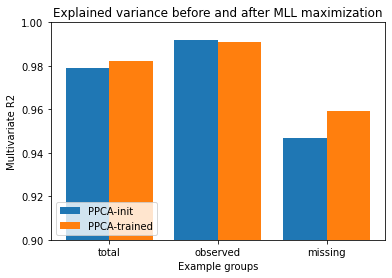

In [50]:
# barplot comparing pre vs post training

import numpy as np 
import matplotlib.pyplot as plt 
  
labels = list(r_squared_untrained.keys())
r2_previous = list(r_squared_untrained.values())
r2_new = list(r_squared_new.values())
  
X_axis = np.arange(len(labels))
  
plt.bar(X_axis - 0.2, r2_previous, 0.4, label = 'PPCA-init')
plt.bar(X_axis + 0.2, r2_new, 0.4, label = 'PPCA-trained')
plt.ylim([0.90, 1.0])
plt.xticks(X_axis, labels)
plt.xlabel("Example groups")
plt.ylabel("Multivariate R2")
plt.title("Explained variance before and after MLL maximization")
plt.legend(loc="lower left")
plt.show()

Perform outlier detection and fixing, if needed.
first filter confidence out. 
then do iterative procedure.

In [104]:
outlier_detector = PPCAOutlierDetector(fitted_model=ppca, \
                                       included_keypoints=keypoint_names, \
                                       displacement_thresh = 50.0)

In [105]:
def mask_preds_by_confs(preds, confs, thresh):
    
    mask = confs < thresh
    tiled_mask = np.tile(np.expand_dims(mask,-1), (1,1, 2)) # duplicate for (x,y)
    preds = torch.clone(preds.reshape(preds.shape[0], -1, 2))
    preds[tiled_mask] = torch.nan
    
    return preds.reshape(preds.shape[0], -1)



    


In [106]:
masked_preds = mask_preds_by_confs(keypoints_pred, confidences, 0.00)

In [107]:
# plt.plot(confidences[0])
# plt.hlines(y=0.05, xmin = 0, xmax = confidences.shape[1])

In [108]:
torch.allclose(masked_preds, keypoints_pred)
assert (~torch.isnan(masked_preds).any())

In [109]:
flagged_preds = torch.zeros_like(keypoints_pred)
fixed_preds = torch.zeros_like(keypoints_pred)
for i in tqdm(range(keypoints_pred.shape[0])):
    out = outlier_detector.flag_and_fix_single_obs(masked_preds[i].float())
    flagged_preds[i] = out["flagged"]
    fixed_preds[i] = out["fixed"]

  1%|          | 10/1045 [00:00<00:10, 99.52it/s]

max_norm: 97.9233169555664
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 99.87212371826172
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 23.136098861694336
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 36.607086181640625
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 35.22876739501953
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 129.1606903076172
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 27.282276153564453
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 36.181888580322266
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 35.4028205871582
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 37.24796676635742
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 24.479

  3%|▎         | 33/1045 [00:00<00:09, 105.83it/s]

max_norm: 12.809086799621582
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 32.52760696411133
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 32.1750373840332
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 67.34728240966797
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is > 50.0, masking bodypart
max_norm: 57.563724517822266
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is > 50.0, masking bodypart
max_norm: 39.817195892333984
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 26.07380485534668
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 31.785024642944336
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 44.18098449707031
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 42.17152404785156
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 28.10064697

  6%|▌         | 58/1045 [00:00<00:08, 111.44it/s]

max_norm: 25.477954864501953
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 29.20277976989746
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 90.6414794921875
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 83.85962677001953
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 28.690128326416016
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 25.327646255493164
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 25.08263397216797
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 12.976031303405762
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 29.010950088500977
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 27.488239288330078
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 19.04960441

  8%|▊         | 81/1045 [00:00<00:09, 105.28it/s]

max_norm: 28.62297248840332
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 82.1417007446289
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 35.68633270263672
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 31.750736236572266
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 24.344482421875
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 49.22848892211914
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 26.24470329284668
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 103.2462387084961
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 95.03756713867188
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 34.29206085205078
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 30.3779125

 10%|▉         | 103/1045 [00:00<00:09, 100.73it/s]

max_norm: 29.176830291748047
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 28.36473846435547
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 32.74162673950195
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 38.03125762939453
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 52.913970947265625
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 69.21354675292969
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 53.41553497314453
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is > 50.0, masking bodypart
max_norm: 30.352060317993164
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 103.65973663330078
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 56.396305084228516
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is > 50.0, masking bodypart
m

 12%|█▏        | 127/1045 [00:01<00:08, 105.37it/s]

max_norm: 27.898448944091797
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 144.14381408691406
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 21.914867401123047
max_norm_ind: 4
max_norm_name: tailBase_top
norm is < 50.0, breaking
max_norm: 16.00862693786621
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 38.05828857421875
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 19.491247177124023
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 31.53656768798828
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 31.051559448242188
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 27.404024124145508
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 18.84950828552246
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 25.894454956054688
max_

 13%|█▎        | 138/1045 [00:01<00:09, 99.24it/s] 

max_norm: 30.182077407836914
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 95.97105407714844
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 22.157299041748047
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 145.2533721923828
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 29.757354736328125
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 106.34427642822266
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 116.88189697265625
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 33.34721755981445
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 33.532344818115234
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 19.255979537963867
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_n

 15%|█▌        | 158/1045 [00:01<00:09, 95.95it/s]

max_norm: 37.552364349365234
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 39.569854736328125
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 30.73041343688965
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is < 50.0, breaking
max_norm: 40.945804595947266
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 27.084535598754883
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 57.35285568237305
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is > 50.0, masking bodypart
max_norm: 36.547523498535156
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 114.49856567382812
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 18.059337615966797
max_norm_ind: 4
max_norm_name: tailBase_top
norm is < 50.0, breaking
max_norm: 35.170989990234375
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 28.24588

 17%|█▋        | 180/1045 [00:01<00:08, 96.83it/s]

max_norm: 22.138668060302734
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 36.20539855957031
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 34.48585891723633
max_norm_ind: 8
max_norm_name: paw2LF_bot
norm is < 50.0, breaking
max_norm: 24.73871421813965
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 27.89885902404785
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 26.850379943847656
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 47.525123596191406
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 31.075199127197266
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 139.72879028320312
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 20.397314071655273
max_norm_ind: 4
max_norm_name: tailBase_top
norm is < 50.0, breaking
max_norm: 19.151401519775

 19%|█▉        | 201/1045 [00:01<00:08, 99.33it/s]

max_norm: 32.970611572265625
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 34.296424865722656
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 35.20586013793945
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 26.834550857543945
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 28.655485153198242
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 34.501285552978516
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is < 50.0, breaking
max_norm: 41.984825134277344
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is < 50.0, breaking
max_norm: 49.95145034790039
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 31.29796028137207
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 26.984567642211914
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 24.487089157104492
max

 22%|██▏       | 226/1045 [00:02<00:07, 106.96it/s]

max_norm: 41.36579895019531
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 36.5030517578125
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 31.288848876953125
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 31.219436645507812
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 40.35072708129883
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 39.708106994628906
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 36.42076110839844
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 35.998966217041016
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 36.608741760253906
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 35.520076751708984
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 36.770408630371

 24%|██▍       | 251/1045 [00:02<00:07, 108.66it/s]

max_norm: 35.895416259765625
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 19.229875564575195
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 25.942031860351562
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 54.668521881103516
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is > 50.0, masking bodypart
max_norm: 34.45624542236328
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 65.73502349853516
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is > 50.0, masking bodypart
max_norm: 83.32569122314453
max_norm_ind: 11
max_norm_name: tailBase_bot
norm is > 50.0, masking bodypart
max_norm: 51.4920768737793
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is > 50.0, masking bodypart
max_norm: 16.246965408325195
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 60.235595703125
max_norm_ind: 11
max_norm_name: tailBase_bot
norm is > 50.0, masking bo

 25%|██▌       | 262/1045 [00:02<00:07, 106.58it/s]

max_norm: 16.963096618652344
max_norm_ind: 9
max_norm_name: paw3RF_bot
norm is < 50.0, breaking
max_norm: 139.45706176757812
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 24.07132911682129
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 134.52059936523438
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 28.1767635345459
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 77.85310363769531
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 26.40155029296875
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 30.453208923339844
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 35.88032531738281
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 39.61009216308594
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 43.5

 27%|██▋       | 286/1045 [00:02<00:07, 106.63it/s]

max_norm: 127.5638198852539
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 32.80791473388672
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 51.59843444824219
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is > 50.0, masking bodypart
max_norm: 51.918033599853516
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is > 50.0, masking bodypart
max_norm: 60.61030578613281
max_norm_ind: 11
max_norm_name: tailBase_bot
norm is > 50.0, masking bodypart
max_norm: 48.85792922973633
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 39.66352844238281
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 24.5535945892334
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 68.8635482788086
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 32.557777404785156
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, break

 29%|██▉       | 308/1045 [00:02<00:07, 104.00it/s]

max_norm: 122.58784484863281
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 21.423006057739258
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 20.236370086669922
max_norm_ind: 8
max_norm_name: paw2LF_bot
norm is < 50.0, breaking
max_norm: 17.941736221313477
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 32.828147888183594
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 26.268131256103516
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 19.239673614501953
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 20.848478317260742
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 29.392059326171875
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 34.557804107666016
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 24.813154220581

 32%|███▏      | 333/1045 [00:03<00:06, 112.01it/s]

max_norm: 25.720569610595703
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 44.875831604003906
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 28.3481502532959
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 100.68880462646484
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 22.554067611694336
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 19.488523483276367
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 17.638795852661133
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 32.02824020385742
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 34.45543670654297
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 9.363962173461914
max_norm_ind: 9
max_norm_name: paw3RF_bot
norm is < 50.0, breaking
max_norm: 39.344329833984375
max

 34%|███▍      | 359/1045 [00:03<00:05, 118.99it/s]

max_norm: 15.812732696533203
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 38.48377990722656
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 29.22272491455078
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 27.414020538330078
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 37.205204010009766
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 22.110721588134766
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 24.273881912231445
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 38.819236755371094
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 17.899999618530273
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 15.459511756896973
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 26.022476196289062
max

 37%|███▋      | 383/1045 [00:03<00:05, 115.41it/s]

max_norm: 102.89888000488281
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 97.16627502441406
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 31.736831665039062
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 27.318544387817383
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 19.24346351623535
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 31.58850860595703
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 27.935138702392578
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 25.95481300354004
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 26.10602378845215
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 11.035058975219727
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 108.580711

 38%|███▊      | 395/1045 [00:03<00:06, 105.79it/s]

norm is < 50.0, breaking
max_norm: 28.12421226501465
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 108.65281677246094
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 100.2937240600586
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 19.01724624633789
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 110.23333740234375
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 125.2406234741211
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 18.148086547851562
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 114.8930435180664
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 18.56599998474121
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 24.19379425048828
max_norm_ind: 0
max_norm_name: paw1LH_to

 40%|████      | 418/1045 [00:03<00:05, 108.75it/s]

max_norm: 32.107173919677734
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 33.91326141357422
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 41.192543029785156
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 17.27093505859375
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 64.89732360839844
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 38.0537109375
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 20.07982635498047
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 21.08279800415039
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 20.150413513183594
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 27.002483367919922
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 18.75183868408203
ma

 42%|████▏     | 441/1045 [00:04<00:05, 108.16it/s]

max_norm: 23.72227668762207
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 28.477405548095703
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 34.06135177612305
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 19.530029296875
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 26.398921966552734
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 23.360816955566406
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 14.907479286193848
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 26.56431007385254
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 64.17565155029297
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is > 50.0, masking bodypart
max_norm: 41.44554901123047
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 26.061031341552734


 44%|████▍     | 465/1045 [00:04<00:05, 114.09it/s]

max_norm: 21.414398193359375
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 15.312735557556152
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 15.819955825805664
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is < 50.0, breaking
max_norm: 19.761558532714844
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 29.214736938476562
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 26.628978729248047
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is < 50.0, breaking
max_norm: 45.19722366333008
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 29.63487434387207
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 43.351341247558594
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 17.32593536376953
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 33.02330017089844
max_nor

 47%|████▋     | 490/1045 [00:04<00:04, 116.39it/s]

norm is < 50.0, breaking
max_norm: 16.838260650634766
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 13.722870826721191
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 24.701086044311523
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 50.10471725463867
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is > 50.0, masking bodypart
max_norm: 34.206851959228516
max_norm_ind: 11
max_norm_name: tailBase_bot
norm is < 50.0, breaking
max_norm: 47.5003662109375
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 22.967241287231445
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 34.8221549987793
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 35.24625015258789
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 124.79393005371094
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking

 49%|████▉     | 515/1045 [00:04<00:04, 113.84it/s]

max_norm: 41.7857780456543
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 48.995155334472656
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 19.029407501220703
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 19.404502868652344
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 28.31570816040039
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 27.662837982177734
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 25.88570213317871
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 48.02116394042969
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 19.89997100830078
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 23.24207878112793
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 22.789581298828125
max_norm_in

 50%|█████     | 527/1045 [00:04<00:05, 96.25it/s] 

max_norm: 46.14370346069336
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 65.79375457763672
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is > 50.0, masking bodypart
max_norm: 59.05674743652344
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is > 50.0, masking bodypart
max_norm: 44.77802658081055
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is < 50.0, breaking
max_norm: 59.504329681396484
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is > 50.0, masking bodypart
max_norm: 58.325923919677734
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is > 50.0, masking bodypart
max_norm: 33.30979537963867
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is < 50.0, breaking
max_norm: 39.157691955566406
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 27.015920639038086
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 22.50737190246582
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 

 52%|█████▏    | 548/1045 [00:05<00:05, 90.35it/s]

max_norm: 60.27475357055664
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is > 50.0, masking bodypart
max_norm: 35.4139289855957
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is < 50.0, breaking
max_norm: 38.493247985839844
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 24.769155502319336
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 37.57392501831055
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 24.002546310424805
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 23.870182037353516
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 33.199642181396484
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 36.124691009521484
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 48.281982421875
max_norm_ind: 8
max_norm_name: paw2LF_bot
norm is < 50.0, breaking
max_norm: 43.61903762817383

 55%|█████▍    | 572/1045 [00:05<00:04, 103.48it/s]

max_norm: 34.69511032104492
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 21.785097122192383
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 136.62159729003906
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 18.151470184326172
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 25.780038833618164
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 19.44312858581543
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 29.081592559814453
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 48.34339904785156
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 21.71643829345703
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 40.273067474365234
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 29.85559654235

 57%|█████▋    | 594/1045 [00:05<00:04, 105.36it/s]

max_norm: 37.190921783447266
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 18.223379135131836
max_norm_ind: 8
max_norm_name: paw2LF_bot
norm is < 50.0, breaking
max_norm: 17.330402374267578
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 15.539617538452148
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 99.5360107421875
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 29.6458683013916
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 19.669584274291992
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 22.674530029296875
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 14.39937686920166
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 43.64700698852539
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 138.32818603515625
max_no

 59%|█████▉    | 616/1045 [00:05<00:04, 97.95it/s] 


norm is < 50.0, breaking
max_norm: 22.111177444458008
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 18.382667541503906
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 33.19297790527344
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 34.106075286865234
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 18.052642822265625
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 102.28437805175781
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 114.75528717041016
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 28.42018699645996
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 22.428367614746094
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 44.1680908203125
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, 

 60%|█████▉    | 626/1045 [00:06<00:04, 92.23it/s]

max_norm: 140.8917694091797
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 26.747421264648438
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 27.698192596435547
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 93.52472686767578
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 107.05457305908203
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 29.970218658447266
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 37.58869171142578
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 21.18168067932129
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 139.719970703125
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 24.425884246826172
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_nor

 62%|██████▏   | 646/1045 [00:06<00:04, 82.46it/s]

norm is > 50.0, masking bodypart
max_norm: 40.279083251953125
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 19.676746368408203
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 19.885929107666016
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 146.72264099121094
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 21.044275283813477
max_norm_ind: 4
max_norm_name: tailBase_top
norm is < 50.0, breaking
max_norm: 28.539817810058594
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 103.97041320800781
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 121.17524719238281
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 30.620798110961914
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 145.3188934326172
max_norm_ind: 5
max_norm_name: tailMid_top


 64%|██████▍   | 667/1045 [00:06<00:04, 91.80it/s]

max_norm: 61.81504440307617
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is > 50.0, masking bodypart
max_norm: 55.30192184448242
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is > 50.0, masking bodypart
max_norm: 32.74736404418945
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 133.41012573242188
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 21.944595336914062
max_norm_ind: 4
max_norm_name: tailBase_top
norm is < 50.0, breaking
max_norm: 32.314205169677734
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 31.12664794921875
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 33.23699951171875
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 33.5611686706543
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 33.56116485595703
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 36.8636512

 66%|██████▌   | 688/1045 [00:06<00:03, 94.26it/s]

max_norm: 54.90857696533203
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is > 50.0, masking bodypart
max_norm: 35.30617904663086
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 80.37750244140625
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is > 50.0, masking bodypart
max_norm: 84.41586303710938
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is > 50.0, masking bodypart
max_norm: 48.23712921142578
max_norm_ind: 11
max_norm_name: tailBase_bot
norm is < 50.0, breaking
max_norm: 31.443084716796875
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 17.783275604248047
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 21.700042724609375
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 33.85093307495117
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 15.710814476013184
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 29.0

 67%|██████▋   | 698/1045 [00:06<00:03, 86.91it/s]

max_norm: 17.0203800201416
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is < 50.0, breaking
max_norm: 38.371036529541016
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 140.7080078125
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 36.39335632324219
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 101.0190200805664
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 124.53096008300781
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 39.2014274597168
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 141.45057678222656
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 35.738834381103516
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 128.7025146484375
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_

 69%|██████▊   | 717/1045 [00:07<00:03, 83.95it/s]

max_norm: 30.68568992614746
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 57.36091613769531
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 26.25628089904785
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 96.68834686279297
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 118.73844146728516
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 34.88016891479492
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 35.3699951171875
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 11.817578315734863
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 123.69367218017578
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 44.25674819946289
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm:

 71%|███████   | 737/1045 [00:07<00:03, 85.99it/s]

max_norm: 31.47416877746582
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 32.41657638549805
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 31.956668853759766
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 48.108551025390625
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 39.40449142456055
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 92.88449096679688
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 129.7425994873047
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 32.50242614746094
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 25.198266983032227
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 23.603965759277344
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 31.6447

 72%|███████▏  | 757/1045 [00:07<00:03, 89.45it/s]

max_norm: 15.368463516235352
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 25.00847053527832
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 22.831531524658203
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 105.00184631347656
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 101.1778793334961
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 52.68867492675781
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is > 50.0, masking bodypart
max_norm: 27.662364959716797
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 97.65960693359375
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 109.25619506835938
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 16.728897094726562
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, break

 73%|███████▎  | 768/1045 [00:07<00:02, 94.70it/s]

max_norm: 34.37186050415039
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 24.057628631591797
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 24.40726089477539
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 24.80303382873535
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 23.360618591308594
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 35.33642578125
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 27.949966430664062
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 55.33570098876953
max_norm_ind: 8
max_norm_name: paw2LF_bot
norm is > 50.0, masking bodypart
max_norm: 35.731075286865234
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 58.517791748046875
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is > 50.0, masking bodypart
max_norm: 40.51577377319336
max_

 76%|███████▌  | 793/1045 [00:07<00:02, 101.01it/s]

max_norm: 74.5394058227539
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 27.186723709106445
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 103.14419555664062
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 94.1546859741211
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 32.54575729370117
max_norm_ind: 8
max_norm_name: paw2LF_bot
norm is < 50.0, breaking
max_norm: 36.28228759765625
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 34.4273567199707
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 27.14274787902832
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 19.28396224975586
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 17.542869567871094
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 24.04

 78%|███████▊  | 818/1045 [00:08<00:02, 112.28it/s]

max_norm: 36.000946044921875
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 39.762535095214844
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 29.24366569519043
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 25.415775299072266
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is < 50.0, breaking
max_norm: 38.017574310302734
max_norm_ind: 9
max_norm_name: paw3RF_bot
norm is < 50.0, breaking
max_norm: 49.0070686340332
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 37.42450714111328
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 40.77132034301758
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 40.95018768310547
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 35.05508804321289
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 39.96473693847656
max_

 79%|███████▉  | 830/1045 [00:08<00:02, 104.03it/s]

norm is > 50.0, masking bodypart
max_norm: 40.6157112121582
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is < 50.0, breaking
max_norm: 31.384721755981445
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 61.51653289794922
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is > 50.0, masking bodypart
max_norm: 36.74577331542969
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is < 50.0, breaking
max_norm: 29.382612228393555
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 21.391117095947266
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 43.917030334472656
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 43.835609436035156
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 43.30891418457031
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 103.84439086914062
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, ma

 82%|████████▏ | 852/1045 [00:08<00:02, 89.43it/s] 

max_norm: 17.197280883789062
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 20.4748592376709
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 30.147396087646484
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 38.426605224609375
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 41.456138610839844
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 45.82085037231445
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 46.031593322753906
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 37.51134490966797
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 51.74105453491211
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is > 50.0, masking bodypart
max_norm: 37.8390007019043
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 28.20107460021972

 84%|████████▍ | 878/1045 [00:08<00:01, 104.50it/s]

max_norm: 35.19136047363281
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 37.176910400390625
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 45.53874206542969
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 46.529354095458984
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 43.00301742553711
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 18.609270095825195
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 51.94782257080078
max_norm_ind: 8
max_norm_name: paw2LF_bot
norm is > 50.0, masking bodypart
max_norm: 19.72127914428711
max_norm_ind: 9
max_norm_name: paw3RF_bot
norm is < 50.0, breaking
max_norm: 36.32575988769531
max_norm_ind: 8
max_norm_name: paw2LF_bot
norm is < 50.0, breaking
max_norm: 45.02644729614258
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 45.97838973999023

 86%|████████▌ | 900/1045 [00:08<00:01, 104.46it/s]

max_norm: 45.12074279785156
max_norm_ind: 4
max_norm_name: tailBase_top
norm is < 50.0, breaking
max_norm: 28.634740829467773
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 27.9683780670166
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 22.00729751586914
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 38.78269577026367
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 38.56207275390625
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 45.48897171020508
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 32.925926208496094
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 23.6070556640625
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 47.09571075439453
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 31.000734329223633
max_norm

 88%|████████▊ | 922/1045 [00:09<00:01, 101.29it/s]

max_norm: 20.9971923828125
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 33.43640899658203
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 25.25047492980957
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 28.160694122314453
max_norm_ind: 5
max_norm_name: tailMid_top
norm is < 50.0, breaking
max_norm: 24.461868286132812
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 29.307132720947266
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 48.453670501708984
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 105.05937194824219
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 41.69221496582031
max_norm_ind: 4
max_norm_name: tailBase_top
norm is < 50.0, breaking
max_norm: 79.10782623291016
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 100.79

 91%|█████████ | 947/1045 [00:09<00:00, 109.38it/s]

max_norm: 31.601436614990234
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 23.777528762817383
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 34.591678619384766
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 35.307395935058594
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 36.72486114501953
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 29.945714950561523
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 43.06829071044922
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 45.63643264770508
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 35.35274124145508
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 20.744365692138672
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 27.1344566345214

 92%|█████████▏| 960/1045 [00:09<00:00, 115.14it/s]

max_norm: 33.639442443847656
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 24.308473587036133
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 21.735273361206055
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 33.88350296020508
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 28.349620819091797
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 33.883487701416016
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 45.5340690612793
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 45.7387809753418
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 48.010990142822266
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 48.623619079589844
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 48.70372009277344
max

 94%|█████████▍| 985/1045 [00:09<00:00, 110.94it/s]

max_norm: 31.0847225189209
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 16.632474899291992
max_norm_ind: 9
max_norm_name: paw3RF_bot
norm is < 50.0, breaking
max_norm: 19.221107482910156
max_norm_ind: 1
max_norm_name: paw2LF_top
norm is < 50.0, breaking
max_norm: 23.143402099609375
max_norm_ind: 9
max_norm_name: paw3RF_bot
norm is < 50.0, breaking
max_norm: 33.67815399169922
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 33.0273323059082
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 32.46236038208008
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 35.59954833984375
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking
max_norm: 36.29500198364258
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 38.084232330322266
max_norm_ind: 2
max_norm_name: paw3RF_top
norm is < 50.0, breaking
max_norm: 37.00773239135742
max_norm_ind: 12
m

 95%|█████████▌| 997/1045 [00:09<00:00, 108.64it/s]

max_norm: 44.498329162597656
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 92.81771850585938
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is > 50.0, masking bodypart
max_norm: 57.10801696777344
max_norm_ind: 10
max_norm_name: paw4RH_bot
norm is > 50.0, masking bodypart
max_norm: 50.78968048095703
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is > 50.0, masking bodypart
max_norm: 21.240819931030273
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 50.0, breaking
max_norm: 87.522705078125
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 118.52621459960938
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 42.55723571777344
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 64.12969207763672
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 95.26155090332031
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, mas

 98%|█████████▊| 1022/1045 [00:10<00:00, 96.32it/s]

max_norm: 56.41099166870117
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is > 50.0, masking bodypart
max_norm: 20.638263702392578
max_norm_ind: 0
max_norm_name: paw1LH_top
norm is < 50.0, breaking
max_norm: 43.722103118896484
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 44.79839324951172
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 23.183446884155273
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 36.756324768066406
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 27.47962188720703
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 35.496421813964844
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 27.3864688873291
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 33.801944732666016
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 28.92884445

100%|█████████▉| 1043/1045 [00:10<00:00, 87.63it/s]

max_norm: 79.44470977783203
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 32.393577575683594
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 96.80008697509766
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 75.74871063232422
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 31.83034324645996
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking
max_norm: 57.06623077392578
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is > 50.0, masking bodypart
max_norm: 81.79766845703125
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 98.27630615234375
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 45.74285888671875
max_norm_ind: 11
max_norm_name: tailBase_bot
norm is < 50.0, breaking
max_norm: 58.17815399169922
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is

100%|██████████| 1045/1045 [00:10<00:00, 100.56it/s]

norm is < 50.0, breaking
max_norm: 45.295406341552734
max_norm_ind: 12
max_norm_name: tailMid_bot
norm is < 50.0, breaking


In [110]:
flagged_preds = flagged_preds.reshape(flagged_preds.shape[0], -1, 2)

In [111]:
is_keypoint_flagged = flagged_preds.isnan().any(2)

In [112]:
# for vanilla pca error we reconstruct
ppca_pred_recons = torch.zeros_like(keypoints_pred)
for i in tqdm(range(keypoints_pred.shape[0])):
    ppca_pred_recons[i,:] = ppca.reconstruct(keypoints_pred[i,:].float().unsqueeze(-1))["reconstruction"][0].squeeze()

100%|██████████| 1045/1045 [00:00<00:00, 2909.29it/s]


In [113]:
keypoints_pred_reshaped = keypoints_pred.reshape(keypoints_pred.shape[0], -1, 2)
ppca_pred_recons_reshaped = ppca_pred_recons.reshape(ppca_pred_recons.shape[0], -1, 2)
ppca_error = torch.linalg.norm(ppca_pred_recons_reshaped - keypoints_pred_reshaped, dim=2)
ppca_error.shape

torch.Size([1045, 14])

In [114]:
# compute pixel errors from gt
gt_reshaped = keypoints_gt.reshape(keypoints_gt.shape[0], -1, 2)
pixel_errors = torch.linalg.norm(keypoints_pred_reshaped - gt_reshaped, dim=2)
pixel_errors.shape

torch.Size([1045, 14])

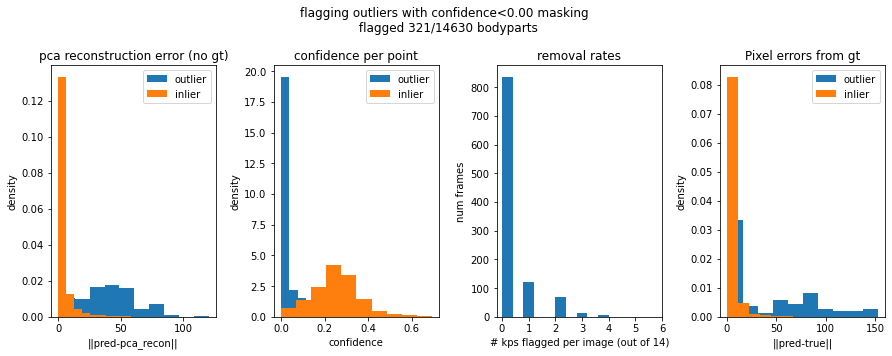

In [115]:
plt.figure(figsize=(12.5,5))
plt.subplot(141)
plt.hist(ppca_error[is_keypoint_flagged].detach().numpy(), label="outlier", density=True)
plt.hist(ppca_error[~is_keypoint_flagged].detach().numpy(), label="inlier", density=True)
plt.legend()
plt.xlabel("||pred-pca_recon||")
plt.ylabel("density")
plt.title("pca reconstruction error (no gt)")
plt.subplot(142)
plt.hist(confidences[is_keypoint_flagged], label="outlier", density=True)
plt.hist(confidences[~is_keypoint_flagged], label="inlier", density=True)
plt.legend()
plt.xlabel("confidence")
plt.ylabel("density")
plt.title("confidence per point")
plt.subplot(143)
plt.hist(is_keypoint_flagged.sum(1).numpy())
plt.xlabel("# kps flagged per image (out of 14)")
plt.ylabel("num frames")
plt.title("removal rates")
plt.xticks(np.arange(7))
plt.subplot(144)
plt.hist(pixel_errors[is_keypoint_flagged].detach().numpy(), label="outlier", density=True)
plt.hist(pixel_errors[~is_keypoint_flagged].detach().numpy(), label="inlier", density=True)
plt.legend()
plt.xlabel("||pred-true||")
plt.ylabel("density")
plt.title("Pixel errors from gt")
plt.suptitle("flagging outliers with confidence<0.00 masking \n flagged %i/%i bodyparts" %(torch.sum(is_keypoint_flagged)
, torch.numel(is_keypoint_flagged)))
plt.tight_layout()

In [116]:
ppca_error.shape

torch.Size([1045, 14])

In [117]:
# get LOO errors per frame and bp
loo_errs_list = []
with torch.no_grad():
    for i, pred in enumerate(keypoints_pred):
        recon_list = outlier_detector.loo_reconstruction(pred_vector=pred.float())
        norms = outlier_detector.compute_difference_norms(pred.float(), recon_list)
        loo_errs_list.append(norms.diag())
loo_errs = torch.stack(loo_errs_list, 0)

In [118]:
image_names = csv_data.iloc[:,0]
image_names

0          barObstacleScaling1/img1.png
1          barObstacleScaling1/img2.png
2          barObstacleScaling1/img3.png
3          barObstacleScaling1/img4.png
4          barObstacleScaling1/img5.png
                     ...               
1040    barObstacleScaling1/img1041.png
1041    barObstacleScaling1/img1042.png
1042    barObstacleScaling1/img1043.png
1043    barObstacleScaling1/img1044.png
1044    barObstacleScaling1/img1045.png
Name: (bodyparts, coords), Length: 1045, dtype: object

In [119]:
keypoint_names = get_keypoint_names(csv_data, cfg.data.header_rows)
keypoint_names = [kp for kp in keypoint_names if kp not in ['obs_top','obsHigh_bot','obsLow_bot']]
print(keypoint_names)

['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'tailBase_top', 'tailMid_top', 'nose_top', 'paw1LH_bot', 'paw2LF_bot', 'paw3RF_bot', 'paw4RH_bot', 'tailBase_bot', 'tailMid_bot', 'nose_bot']


In [120]:
# make a dataframe with
# bp name
# ppca error (not pca)
# loo error
# pixel error
# frame number/image name
# bool is outlier
ppca_error_np = ppca_error.detach().numpy()
pixel_errors_np = pixel_errors.detach().numpy()
loo_errs_np = loo_errs.detach().numpy()
is_keypoint_flagged_np = is_keypoint_flagged.detach().numpy()

df_list = []
for fr in range(keypoints_pred.shape[0]):
    for bp in range(len(keypoint_names)):
        df_list.append(pd.DataFrame({"keypoint": keypoint_names[bp], \
                                     "ppca_error": ppca_error_np[fr, bp], \
                                     "pixel_error": pixel_errors_np[fr, bp], \
                                     "loo_error": loo_errs_np[fr, bp], \
                                     "image_name": image_names[fr], \
                                     "is_outlier": is_keypoint_flagged_np[fr, bp], \
                                     "image_index": fr
                                    }, index=[0]))

In [121]:
df = pd.concat(df_list)
df.head()

keypoint  ppca_error  pixel_error  loo_error  \
0    paw1LH_top   11.010364    40.876352  22.607346   
0    paw2LF_top    4.715446     1.174366   7.350399   
0    paw3RF_top   14.599096     6.527164  28.085958   
0    paw4RH_top   12.075287     6.488440  27.813013   
0  tailBase_top   32.202857          NaN  59.769161   

                     image_name  is_outlier  image_index  
0  barObstacleScaling1/img1.png       False            0  
0  barObstacleScaling1/img1.png       False            0  
0  barObstacleScaling1/img1.png       False            0  
0  barObstacleScaling1/img1.png       False            0  
0  barObstacleScaling1/img1.png        True            0

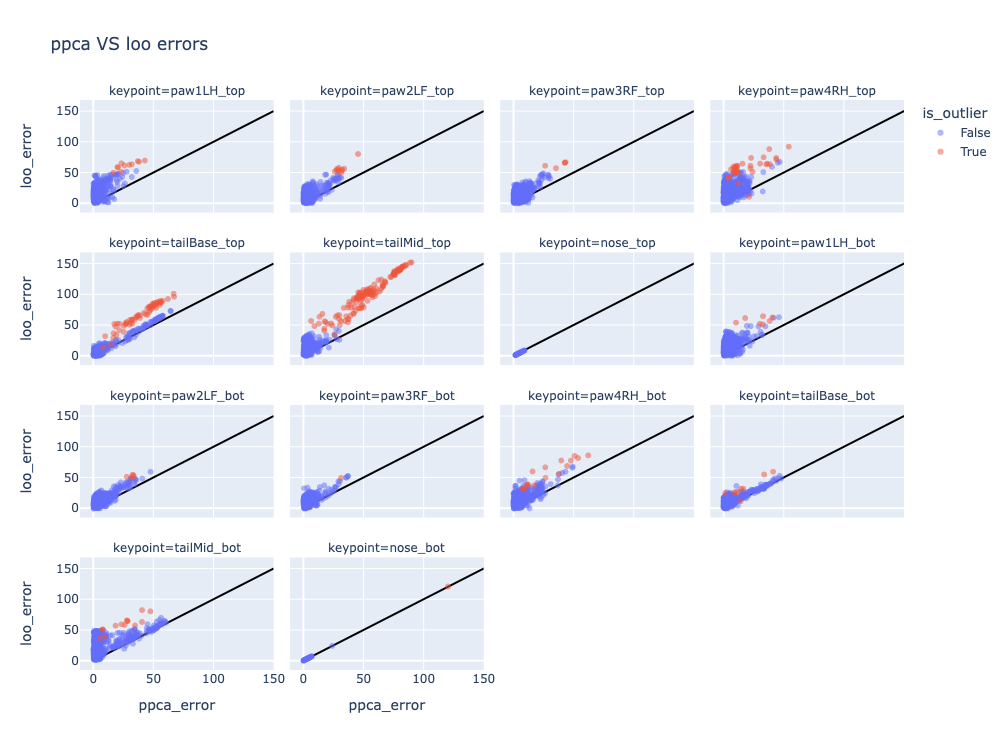

In [132]:
import plotly.express as px
import plotly.graph_objects as go

n_cols = 4
title = "ppca VS loo errors"
fig_width = 1000
fig_height = 750
fig_scatter = px.scatter(
    df,
    x="ppca_error", y="loo_error",
    color="is_outlier",
    facet_col="keypoint", facet_col_wrap=n_cols,
    #log_x=log_scatter, log_y=log_scatter,
    opacity=0.5,
    hover_data=['image_name', "image_index"],
    #trendline="ols",
    title=title,
    # labels={model_0: xlabel_, model_1: ylabel_},
)
mn = 0
mx = 150
trace = go.Scatter(x=[mn, mx], y=[mn, mx], line_color="black", mode="lines")
trace.update(legendgroup="trendline", showlegend=False)
fig_scatter.add_trace(trace, row="all", col="all", exclude_empty_subplots=True)
fig_scatter.update_layout(title=title, width=fig_width, height=fig_height)

In [150]:
# threshold
df["ppca_flagged"] = df["ppca_error"] > 50.

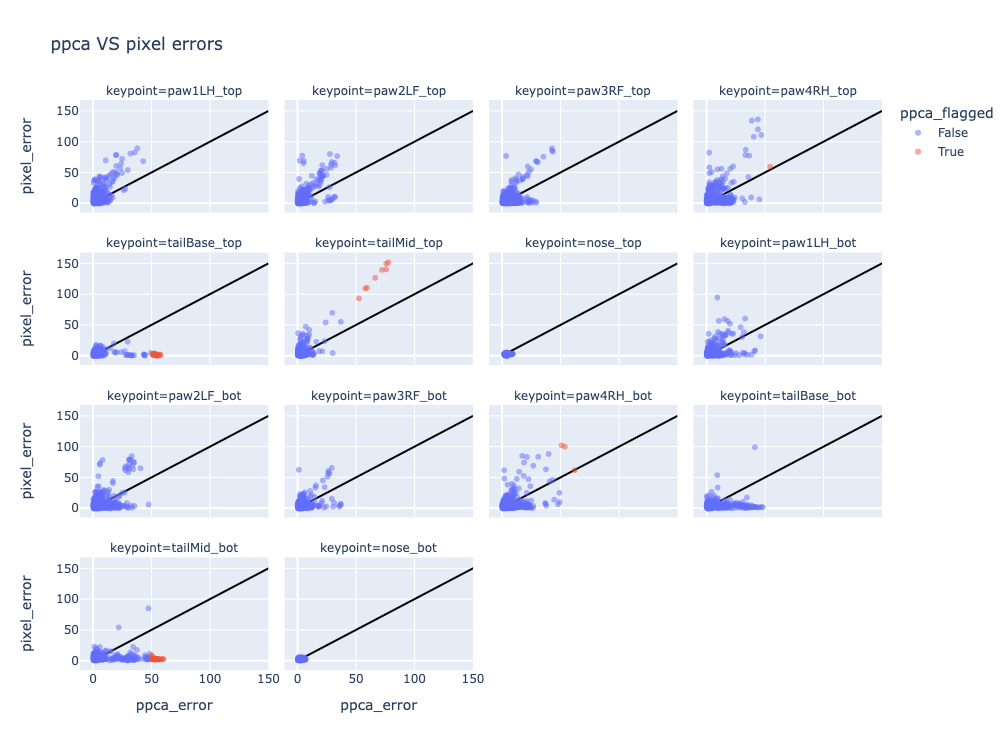

In [184]:
import plotly.express as px
import plotly.graph_objects as go

n_cols = 4
title = "ppca VS pixel errors"
fig_width = 1000
fig_height = 750
fig_scatter = px.scatter(
    df,
    x="ppca_error", y="pixel_error",
    color="ppca_flagged",
    facet_col="keypoint", facet_col_wrap=n_cols,
    #log_x=log_scatter, log_y=log_scatter,
    opacity=0.5,
    hover_data=['image_name', "image_index"],
    #trendline="ols",
    title=title,
    # labels={model_0: xlabel_, model_1: ylabel_},
)
mn = 0
mx = 150
trace = go.Scatter(x=[mn, mx], y=[mn, mx], line_color="black", mode="lines")
trace.update(legendgroup="trendline", showlegend=False)
fig_scatter.add_trace(trace, row="all", col="all", exclude_empty_subplots=True)
fig_scatter.update_layout(title=title, width=fig_width, height=fig_height)

In [156]:
# get reconstructions from ppca
# reconstruct everything again with new model
recons = []
for i, data in enumerate(keypoints_pred):
    recons.append(ppca.reconstruct(data.reshape(-1,1).float()))
reconstructions = torch.hstack([rec["reconstruction"][0].detach().cpu() for rec in recons]).T

In [157]:
reconstructions.shape

torch.Size([1045, 28])

In [180]:
# preds for comparison
# condition = "train"
# inds = np.where(cond == condition)[0]

# img_index = inds[3]
img_index = 634
cond = pred_df["set"].values.reshape(-1)

keypoints_pred_reshaped = keypoints_pred.reshape(keypoints_pred.shape[0], -1, 2)
pred_recons_reshape = reconstructions.reshape(reconstructions.shape[0], -1, 2)
gt_reshaped = keypoints_gt.reshape(keypoints_gt.shape[0], -1, 2)
#gt_recons_reshaped = gt_recons.reshape(gt_recons.shape[0], -1, 2)gle_pred = keypoints_pred_reshaped[img_index, :, :]
single_recons = pred_recons_reshape[img_index, :, :]
single_pred = keypoints_pred_reshaped[img_index, :, :]
single_confs = confidences[img_index, :]
#single_fixed = keypoints_pred_reshaped_fixed[img_index, :, :]
single_gt = gt_reshaped[img_index, :, :]
img_name = image_names[img_index]
file_name = os.path.join(cfg.data.data_dir, img_name)
assert os.path.exists(file_name)
image = Image.open(file_name).convert("RGB")

# inds_to_use = pred_df[(pred_df["set"]==eval_cond).to_numpy()].index.values
# img_index = 55
# img_name = csv_data.iloc[inds_to_use[img_index],0]
# pred_vector = keypoints_pred[inds_to_use[img_index],:]
# gt_vector = keypoints_gt[inds_to_use[img_index],:]
# conf_vector = confidences[inds_to_use[img_index],:]
# file_name = os.path.join(cfg.data.data_dir, img_name)
# assert os.path.exists(file_name)
#         # if 1 color channel, change to 3.
# image = Image.open(file_name).convert("RGB")

In [183]:
masked_preds = mask_preds_by_confs(single_preds, single_confs, 0.00)
masked_preds

IndexError: The shape of the mask [14, 2] at index 1 does not match the shape of the indexed tensor [14, 1, 2] at index 1

4


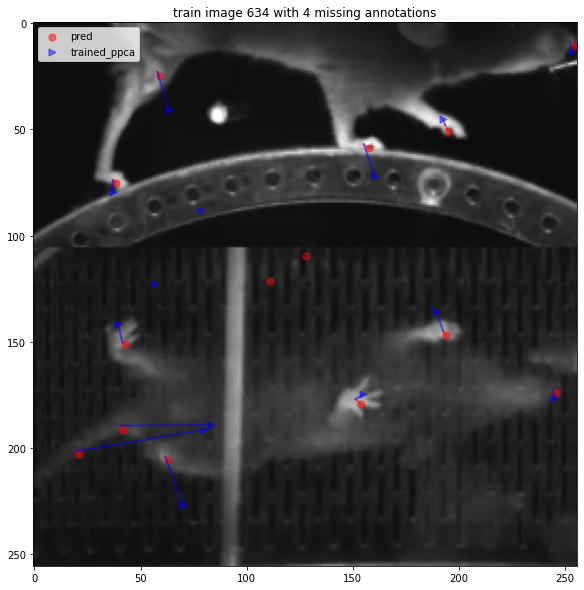

In [177]:
plt.figure(figsize=(10,10))
plt.imshow(image.resize((256,256)))
nan_count = torch.isnan(single_gt).sum()
print(int(nan_count))
scatter_and_line(gt_vector= single_gt, pred_vector= single_pred, \
                 label="pred", color="red", marker="o", s= 50., alpha_marker=.5, alpha_line=.5, show_nans= True)
scatter_and_line(gt_vector= single_gt, pred_vector= single_recons, \
                 label="trained_ppca", color="blue", marker=">", s= 50., alpha_marker=.5, alpha_line=.5, show_nans= True)
plt.title("%s image %i with %i missing annotations" %(cond[img_index], img_index, int(nan_count)))
plt.legend()

In [136]:
r_squared_multivariate(torch.tensor(df["ppca_error"]), torch.tensor(df["loo_error"]))

ValueError: too many dimensions 'Series'

In [140]:
df["loo_error"][df["loo_error"]>10.]

0    22.607346
0    28.085958
0    27.813013
0    59.769161
0    97.923317
       ...    
0    14.003413
0    18.495327
0    10.232550
0    19.396416
0    45.295406
Name: loo_error, Length: 8282, dtype: float32

In [147]:
from scipy.stats import pearsonr
pearsonr(df["loo_error"][df["loo_error"]>0.].to_numpy(), df["ppca_error"][df["loo_error"]>0.].to_numpy())

(0.7745802104532882, 0.0)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

n_cols = 4
title = "ppca VS loo errors"
fig_width = 1000
fig_height = 750
fig_scatter = px.scatter(
    df,
    x="ppca_error", y="loo_error",
    color="is_outlier",
    facet_col="keypoint", facet_col_wrap=n_cols,
    #log_x=log_scatter, log_y=log_scatter,
    opacity=0.5,
    hover_data=['image_name', "image_index"],
    #trendline="ols",
    title=title,
    # labels={model_0: xlabel_, model_1: ylabel_},
)
mn = 0
mx = 150
trace = go.Scatter(x=[mn, mx], y=[mn, mx], line_color="black", mode="lines")
trace.update(legendgroup="trendline", showlegend=False)
fig_scatter.add_trace(trace, row="all", col="all", exclude_empty_subplots=True)
fig_scatter.update_layout(title=title, width=fig_width, height=fig_height)

In [123]:
# let's look at image 182
ind_to_check = 881
print(fixed_preds[ind_to_check,:])
print(flagged_preds[ind_to_check,:])
print(ppca_error[ind_to_check,:])
print(loo_errs[ind_to_check, :])

tensor([ 98.3756,  52.8775, 150.7378,  60.7495, 194.0714,  68.7399,  18.3830,
         82.5330,  44.8621,  21.2439,  26.3111,  28.1818, 254.4684,  17.0081,
         98.5581, 151.2938, 148.4162, 168.3263, 192.0118, 203.9873,  28.7024,
        231.1746,  60.2151, 193.0264,  37.6466, 193.8613, 246.0712, 179.4324],
       dtype=torch.float64)
tensor([[ 98.3756,  52.8775],
        [150.7378,  60.7495],
        [194.0714,  68.7399],
        [ 18.3830,  82.5330],
        [     nan,      nan],
        [     nan,      nan],
        [254.4684,  17.0081],
        [ 98.5581, 151.2938],
        [148.4162, 168.3263],
        [192.0118, 203.9873],
        [ 28.7024, 231.1746],
        [ 60.2151, 193.0264],
        [ 37.6466, 193.8613],
        [246.0712, 179.4324]], dtype=torch.float64)
tensor([ 5.1198,  4.5993,  9.5869, 13.8954,  9.8944, 53.1133,  2.1497,  5.5073,
         9.8535,  3.7389, 14.5385, 18.7373, 38.0096,  2.0194],
       dtype=torch.float64, grad_fn=<SliceBackward0>)
tensor([ 13.7975,   

In [124]:
# get LOO errors per frame and bp
loo_errs_list = []
with torch.no_grad():
    pred = keypoints_pred[ind_to_check,:]
    recon_list = outlier_detector.loo_reconstruction(pred_vector=pred.float())
    norms = outlier_detector.compute_difference_norms(pred.float(), recon_list)

In [125]:
out = outlier_detector.flag_and_fix_single_obs(keypoints_pred[ind_to_check,:].float())

max_norm: 104.6158447265625
max_norm_ind: 5
max_norm_name: tailMid_top
norm is > 50.0, masking bodypart
max_norm: 74.98258209228516
max_norm_ind: 4
max_norm_name: tailBase_top
norm is > 50.0, masking bodypart
max_norm: 42.50955581665039
max_norm_ind: 3
max_norm_name: paw4RH_top
norm is < 50.0, breaking


In [103]:
print(out["flagged"])
print(out["fixed"])

tensor([ 94.1072,  66.7523, 142.5390,  62.9021, 198.2161,  62.8681,      nan,
             nan,  22.3069,  57.5641,      nan,      nan, 254.6044,  15.5733,
         95.3750, 145.3946, 139.7912, 152.1609, 193.4337, 190.4515,  48.0276,
        224.0388,  35.1420, 224.3622,  18.1822, 234.6788, 245.9674, 178.7102])
tensor([ 94.1072,  66.7523, 142.5390,  62.9021, 198.2161,  62.8681,  68.0616,
         69.1430,  22.3069,  57.5641,   7.8469,  39.9667, 254.6044,  15.5733,
         95.3750, 145.3946, 139.7912, 152.1609, 193.4337, 190.4515,  48.0276,
        224.0388,  35.1420, 224.3622,  18.1822, 234.6788, 245.9674, 178.7102])


In [92]:
norms.shape

torch.Size([14, 14])

procedure:
we loop over frames. for a given frame
* loop over bodyparts
* for each bodypart, make its (x,y) coordinates == nan. 
* do posterior inference and project back to observation.
* compute norm between raw prediction and the posterior prediction
* if above threshold, mark as an outlier
* proceed to next bodypart with that one masked as nan
issue:
* imagine two bad bodyparts. everything computed on the first bodypart will be contaminated

In [220]:
# preds for comparison
keypoints_pred_reshaped = keypoints_pred.reshape(keypoints_pred.shape[0], -1, 2)
keypoints_pred_reshaped_fixed = fixed_preds.reshape(fixed_preds.shape[0], -1, 2)
gt_reshaped = keypoints_gt.reshape(keypoints_gt.shape[0], -1, 2)
gt_recons_reshaped = gt_recons.reshape(gt_recons.shape[0], -1, 2)

Text(0.5, 1.0, 'flagging outliers')

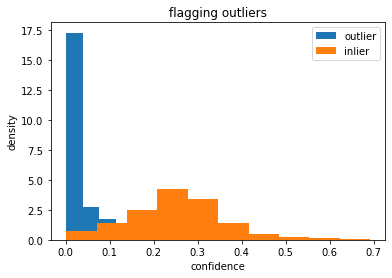

In [148]:
plt.hist(confidences[is_keypoint_flagged], label="outlier", density=True)
plt.hist(confidences[~is_keypoint_flagged], label="inlier", density=True)
plt.legend()
plt.xlabel("confidence")
plt.ylabel("density")
plt.title("flagging outliers")

In [219]:
# reconstruct gt keypoints using ppca
gt_recons = torch.zeros_like(keypoints_gt)
for i in tqdm(range(keypoints_gt.shape[0])):
    # make sure you're using the right model
    gt_recons[i,:] = ppca.reconstruct(keypoints_gt[i,:].float().unsqueeze(-1))["reconstruction"][0].squeeze()

100%|██████████| 1045/1045 [00:00<00:00, 2922.43it/s]


In [221]:
# compute pixel errors
pixel_errors = np.linalg.norm(keypoints_pred_reshaped.detach().numpy() - gt_reshaped.detach().numpy(), axis=2)
pixel_errors_fixed = np.linalg.norm(keypoints_pred_reshaped_fixed.detach().numpy() - gt_reshaped.detach().numpy(), axis=2)
pixel_errors_gt_recons = np.linalg.norm(gt_recons_reshaped.detach().numpy() - gt_reshaped.detach().numpy(), axis=2)
print(pixel_errors.shape)

(1045, 14)


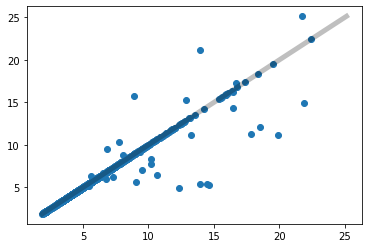

In [223]:
mean_err = np.nanmean(pixel_errors,1)
mean_err_fixed = np.nanmean(pixel_errors_fixed,1)
plt.scatter(mean_err, mean_err_fixed)
minimum, maximum = np.nanmin(mean_err), np.nanmax(mean_err_fixed)
plt.plot([minimum, maximum], [minimum, maximum], linewidth=5.0, c='black', alpha=0.25)

0 train
ppca better: 0.14; worse: 0.12; same: 0.75
ppca better: 0.08; worse: 0.12; same: 0.79
1 validation
ppca better: 0.11; worse: 0.24; same: 0.64
ppca better: 0.21; worse: 0.15; same: 0.65
2 test
ppca better: 0.15; worse: 0.13; same: 0.73
ppca better: 0.16; worse: 0.18; same: 0.66


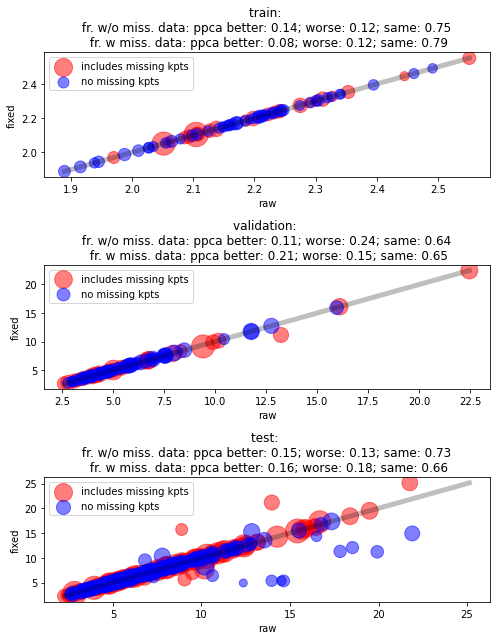

In [224]:
# plot errors for training, testing, validation
cond = pred_df["set"].values.reshape(-1)
fig, ax = plt.subplots(3, figsize=(7,9))
for i, condition in enumerate(["train", "validation", "test"]):
    print(i, condition)
    # define bools
    if condition == "test":
        boolean = ((cond == "test") | (cond == "unused"))
    else:
        boolean = (cond == condition)
    # average over keypoints
    gt_has_nan = np.any(np.isnan(pixel_errors[boolean,:]), axis=1)
    curr_data_raw = np.nanmean(pixel_errors[boolean,:], axis=1)
    curr_data_fixed = np.nanmean(pixel_errors_fixed[boolean,:], axis=1)
    curr_data_gt_recons = np.nanmean(pixel_errors_gt_recons[boolean,:], axis=1)
    minimum, maximum = np.nanmin(curr_data_raw), np.nanmax(curr_data_fixed)
    ax[i].plot([minimum,maximum], [minimum,maximum], linewidth=5.0, c='black', alpha=0.25)
    ax[i].scatter(curr_data_raw[gt_has_nan], curr_data_fixed[gt_has_nan], c= "red", s = curr_data_gt_recons[gt_has_nan]*50.0, label="includes missing kpts", alpha=0.5)
    ax[i].scatter(curr_data_raw[~gt_has_nan], curr_data_fixed[~gt_has_nan], c= "blue",  s = curr_data_gt_recons[~gt_has_nan]*50.0, label="no missing kpts", alpha=0.5)
    ax[i].set_xlabel("raw")
    ax[i].set_ylabel("fixed")
    ax[i].legend()

    bools = [~gt_has_nan, gt_has_nan]
    prop_strs = []
    for j, hasnans_cond in enumerate(bools):
        proportion_better = np.mean(curr_data_raw[hasnans_cond]  - curr_data_fixed[hasnans_cond] > 1e-6)
        proportion_worse = np.mean(curr_data_raw[hasnans_cond]  - curr_data_fixed[hasnans_cond] < -1e-6)
        proportion_same = np.mean(np.abs(curr_data_raw[hasnans_cond]  - curr_data_fixed[hasnans_cond]) < 1e-6)
        string = f"ppca better: {proportion_better:.2f}; worse: {proportion_worse:.2f}; same: {proportion_same:.2f}"
        prop_strs.append(string)
        print(string)
    
    proportion_better = np.mean(curr_data_raw[~gt_has_nan]  - curr_data_fixed[~gt_has_nan] > 1e-6)
    proportion_worse = np.mean(curr_data_raw[~gt_has_nan]  - curr_data_fixed[~gt_has_nan] < -1e-6)
    proportion_same = np.mean(np.abs(curr_data_raw[~gt_has_nan]  - curr_data_fixed[~gt_has_nan]) < 1e-6)
    ax[i].set_title(f"{condition}: \n fr. w/o miss. data: {prop_strs[0]} \n fr. w miss. data: {prop_strs[1]}")
    #ax[i].set_title("%s: \n ppca better: %.2f; worse: %.2f; same: %.2f" % (condition, proportion_better, proportion_worse, proportion_same)) 
fig.tight_layout()

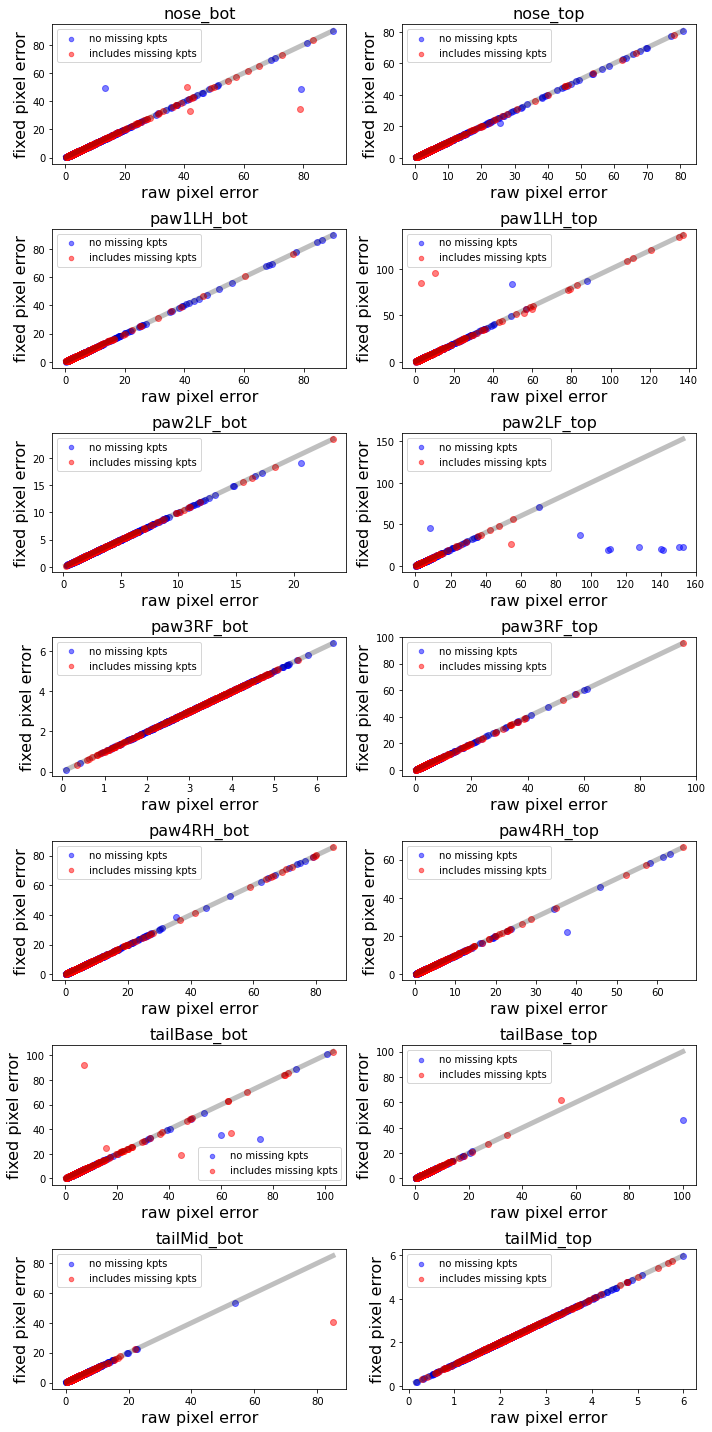

In [227]:
# subplot for each keypoint
ncols = 2
nrows = int(np.ceil(len(keypoint_names) / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,20))
axs = axs.flatten()
gt_has_nan = np.any(np.isnan(pixel_errors), axis=1)
for i, keypoint_name in enumerate(keypoint_names):
    ax = axs[i] # axs.flat[i]
    scatter_obs = ax.scatter(pixel_errors[~gt_has_nan,i], pixel_errors_fixed[~gt_has_nan,i], c= "blue", label="no missing kpts", alpha=0.5) # s = pixel_errors_gt_recons[~gt_has_nan, i]*10.0
    scatter_miss = ax.scatter(pixel_errors[gt_has_nan,i], pixel_errors_fixed[gt_has_nan,i], c= "red", label="includes missing kpts", alpha=0.5) #  s = pixel_errors_gt_recons[gt_has_nan, i]*10.0
    minimum, maximum = np.nanmin(pixel_errors[:,i]), np.nanmax(pixel_errors[:,i])
    ax.plot([minimum, maximum], [minimum, maximum], linewidth=5.0, c='black', alpha=0.25)
    #ax.plot([2,20], [2,20], linewidth=5.0, c='black', alpha=0.25)
    ax.set_xlabel("raw pixel error", fontsize=16)
    ax.set_ylabel("fixed pixel error", fontsize=16)
    ax.set_title(keypoint_name, fontsize=16)
    lgnd = ax.legend()
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [20]

fig.tight_layout()
#plt.savefig("figs/pix_errs.png")


0 train
ppca better: 0.14; worse: 0.12; same: 0.75
ppca better: 0.08; worse: 0.12; same: 0.79
1 validation
ppca better: 0.11; worse: 0.24; same: 0.64
ppca better: 0.21; worse: 0.15; same: 0.65
2 test
ppca better: 0.15; worse: 0.13; same: 0.73
ppca better: 0.16; worse: 0.18; same: 0.66


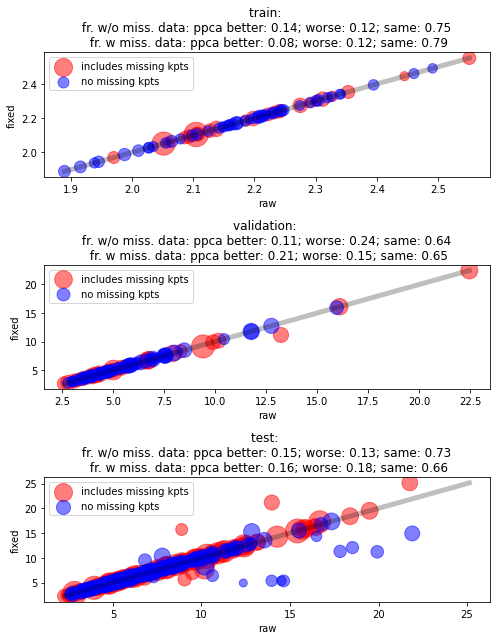

In [226]:
# plot errors for training, testing, validation
fig, ax = plt.subplots(3, figsize=(7,9))
for i, condition in enumerate(["train", "validation", "test"]):
    print(i, condition)
    # define bools
    if condition == "test":
        boolean = ((cond == "test") | (cond == "unused"))
    else:
        boolean = (cond == condition)
    # average over keypoints
    gt_has_nan = np.any(np.isnan(pixel_errors[boolean,:]), axis=1)
    curr_data_raw = np.nanmean(pixel_errors[boolean,:], axis=1)
    curr_data_fixed = np.nanmean(pixel_errors_fixed[boolean,:], axis=1)
    curr_data_gt_recons = np.nanmean(pixel_errors_gt_recons[boolean,:], axis=1)
    minimum, maximum = np.nanmin(curr_data_raw), np.nanmax(curr_data_fixed)
    ax[i].plot([minimum,maximum], [minimum,maximum], linewidth=5.0, c='black', alpha=0.25)
    ax[i].scatter(curr_data_raw[gt_has_nan], curr_data_fixed[gt_has_nan], c= "red", s = curr_data_gt_recons[gt_has_nan]*50.0, label="includes missing kpts", alpha=0.5)
    ax[i].scatter(curr_data_raw[~gt_has_nan], curr_data_fixed[~gt_has_nan], c= "blue",  s = curr_data_gt_recons[~gt_has_nan]*50.0, label="no missing kpts", alpha=0.5)
    ax[i].set_xlabel("raw")
    ax[i].set_ylabel("fixed")
    ax[i].legend()

    bools = [~gt_has_nan, gt_has_nan]
    prop_strs = []
    for j, hasnans_cond in enumerate(bools):
        proportion_better = np.mean(curr_data_raw[hasnans_cond]  - curr_data_fixed[hasnans_cond] > 1e-6)
        proportion_worse = np.mean(curr_data_raw[hasnans_cond]  - curr_data_fixed[hasnans_cond] < -1e-6)
        proportion_same = np.mean(np.abs(curr_data_raw[hasnans_cond]  - curr_data_fixed[hasnans_cond]) < 1e-6)
        string = f"ppca better: {proportion_better:.2f}; worse: {proportion_worse:.2f}; same: {proportion_same:.2f}"
        prop_strs.append(string)
        print(string)
    
    proportion_better = np.mean(curr_data_raw[~gt_has_nan]  - curr_data_fixed[~gt_has_nan] > 1e-6)
    proportion_worse = np.mean(curr_data_raw[~gt_has_nan]  - curr_data_fixed[~gt_has_nan] < -1e-6)
    proportion_same = np.mean(np.abs(curr_data_raw[~gt_has_nan]  - curr_data_fixed[~gt_has_nan]) < 1e-6)
    ax[i].set_title(f"{condition}: \n fr. w/o miss. data: {prop_strs[0]} \n fr. w miss. data: {prop_strs[1]}")
    #ax[i].set_title("%s: \n ppca better: %.2f; worse: %.2f; same: %.2f" % (condition, proportion_better, proportion_worse, proportion_same)) 
fig.tight_layout()

In [37]:
# reconstruct everything again with new model
recons = []
for i, data in enumerate(keypoints_pred):
    recons.append(ppca.reconstruct(data.reshape(-1,1).float()))
reconstructions = torch.hstack([rec["reconstruction"][0].detach().cpu() for rec in recons]).T

In [38]:
untrained_recons = []
for i, data in enumerate(keypoints_pred):
    untrained_recons.append(ppca_untrained.reconstruct(data.reshape(-1,1).float()))
untrained_reconstructions = torch.hstack([rec["reconstruction"][0].detach().cpu() for rec in untrained_recons]).T

In [69]:
# preds for comparison
keypoints_pred_reshaped = keypoints_pred.reshape(keypoints_pred.shape[0], -1, 2)
pred_recons_reshape = reconstructions.reshape(reconstructions.shape[0], -1, 2)
pred_untrained_recons_reshape = untrained_reconstructions.reshape(untrained_reconstructions.shape[0], -1, 2)
#keypoints_pred_reshaped_fixed = fixed_preds.reshape(fixed_preds.shape[0], -1, 2)
gt_reshaped = keypoints_gt.reshape(keypoints_gt.shape[0], -1, 2)
#gt_recons_reshaped = gt_recons.reshape(gt_recons.shape[0], -1, 2)

In [105]:
# preds for comparison
keypoints_pred_reshaped = keypoints_pred.reshape(keypoints_pred.shape[0], -1, 2)
pred_recons_reshape = reconstructions.reshape(reconstructions.shape[0], -1, 2)
pred_untrained_recons_reshape = untrained_reconstructions.reshape(untrained_reconstructions.shape[0], -1, 2)
#keypoints_pred_reshaped_fixed = fixed_preds.reshape(fixed_preds.shape[0], -1, 2)
gt_reshaped = keypoints_gt.reshape(keypoints_gt.shape[0], -1, 2)
#gt_recons_reshaped = gt_recons.reshape(gt_recons.shape[0], -1, 2)gle_pred = keypoints_pred_reshaped[img_index, :, :]
single_recons = pred_recons_reshape[img_index, :, :]
single_untrained_recons = pred_untrained_recons_reshape[img_index, :, :]
#single_fixed = keypoints_pred_reshaped_fixed[img_index, :, :]
single_gt = gt_reshaped[img_index, :, :]
#single_confs = confidences[img_index, :]
file_name = os.path.join(cfg.data.data_dir, img_name)
assert os.path.exists(file_name)
image = Image.open(file_name).convert("RGB")

# inds_to_use = pred_df[(pred_df["set"]==eval_cond).to_numpy()].index.values
# img_index = 55
# img_name = csv_data.iloc[inds_to_use[img_index],0]
# pred_vector = keypoints_pred[inds_to_use[img_index],:]
# gt_vector = keypoints_gt[inds_to_use[img_index],:]
# conf_vector = confidences[inds_to_use[img_index],:]
# file_name = os.path.join(cfg.data.data_dir, img_name)
# assert os.path.exists(file_name)
#         # if 1 color channel, change to 3.
# image = Image.open(file_name).convert("RGB")

In [106]:
single_recons.shape

torch.Size([14, 2])

0


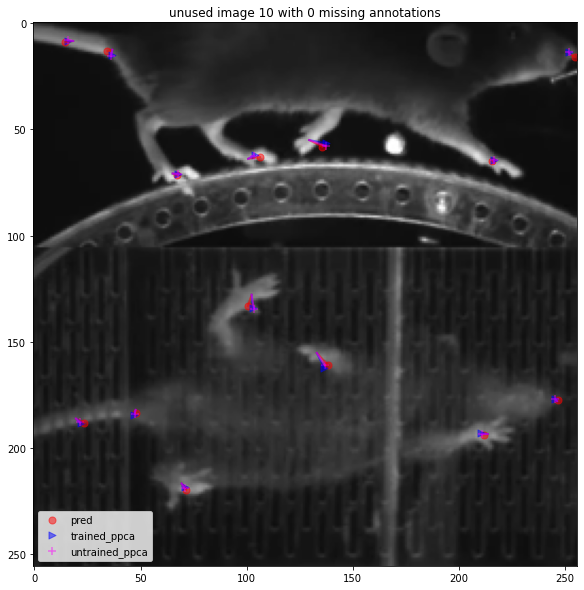

In [107]:
plt.figure(figsize=(10,10))
plt.imshow(image.resize((256,256)))
nan_count = torch.isnan(single_gt).sum()
print(int(nan_count))
scatter_and_line(gt_vector= single_gt, pred_vector= single_pred, \
                 label="pred", color="red", marker="o", s= 50., alpha_marker=.5, alpha_line=.5, show_nans= True)
scatter_and_line(gt_vector= single_gt, pred_vector= single_recons, \
                 label="trained_ppca", color="blue", marker=">", s= 50., alpha_marker=.5, alpha_line=.5, show_nans= True)
scatter_and_line(gt_vector= single_gt, pred_vector=single_untrained_recons , \
                 label="untrained_ppca", color="magenta", marker="+", s= 50., alpha_marker=.5, alpha_line=.5, show_nans= True)
plt.title("%s image %i with %i missing annotations" %(cond, img_index, int(nan_count)))
plt.legend()

In [251]:
reconstructions = torch.hstack([rec["reconstruction"][0].detach().cpu() for rec in recons]).T

In [275]:
arr1 = full_data_arr.reshape(full_data_arr.shape[0], -1, 2)
recon1 = reconstructions.reshape(reconstructions.shape[0], -1, 2)
norms = torch.linalg.norm(arr1 - recon1, axis=2)
mean_norms = torch.nanmean(norms, axis=1)
mean_norms.shape
#arr1.shape
# assert(torch.allclose(arr1[4], full_data_arr[4].reshape(-1,2)))

torch.Size([75])

In [229]:
recons = []
for i, data in enumerate(full_data_arr):
    recons.append(ppca.reconstruct(data.reshape(-1,1)))

In [262]:
ind = 34
print(reconstructions[ind])
print(full_data_arr[ind])
reshaped_data = full_data_arr[ind].reshape(-1,2)
reshaped_recon = reconstructions[ind].reshape(-1,2)
torch.linalg.norm(reshaped_data - reshaped_recon, axis=1).shape
#torch.linalg.norm(full_data_arr[ind].numpy()-reconstructions[ind].numpy())

tensor([ 32.5375,  52.0036, 173.9667,  62.5049, 180.6228,  45.2120,  64.7902,
         71.4097,  24.2789,  11.8729,  10.0814,  15.7637, 251.3018,  12.5224,
         37.8198, 160.5981, 169.1153, 155.9599, 178.8237, 197.6632,  67.1427,
        205.1323,  35.5955, 194.3553,  21.0489, 198.6526, 245.3004, 176.1394])
tensor([ 33.2929,  48.8670, 175.5850,  60.0808, 180.7286,  45.1780,  65.9670,
         68.2475,  21.6566,   1.7025,      nan,      nan, 251.8469,   9.2165,
         38.4646, 161.8601, 170.2341, 163.3832, 179.5002, 196.6755,  65.4229,
        200.1711,  31.8157, 192.6700,  13.4470, 202.4823, 244.8456, 173.2095])


torch.Size([14])

In [186]:
recons[0]["reconstruction"][0].shape

torch.Size([28, 28])

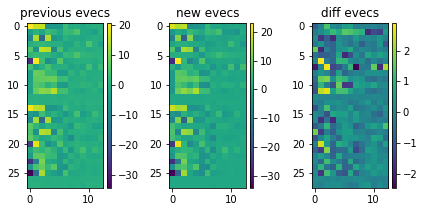

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1,3)
im0 = axs[0].imshow(W.detach().cpu().numpy())#W.detach().cpu().numpy())
axs[0].set_title("previous evecs")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
im1 = axs[1].imshow(ppca.W.detach().cpu().numpy())#ppca.W.detach().cpu().numpy())
axs[1].set_title("new evecs")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
im2 = axs[2].imshow(ppca.W.detach().cpu().numpy() - W.detach().cpu().numpy())#ppca.W.detach().cpu().numpy())
axs[2].set_title("diff evecs")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
fig.tight_layout()
#print(torch.dist(linear_gaussian.observation_projection, W_new))

Text(0.5, 1.0, 'mu parameter')

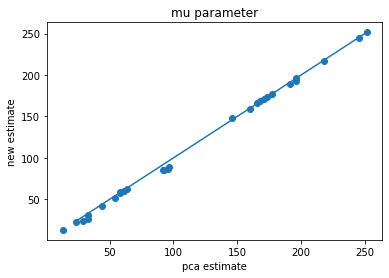

In [125]:
plt.scatter(mu.detach().cpu().numpy(), ppca.mu.detach().cpu().numpy())
plt.plot([25,250],[25,250])
plt.xlabel("pca estimate")
plt.ylabel("new estimate")
plt.title("mu parameter")